# Universidad de Buenos Aires
# Aprendizaje Profundo - TP2
# Cohorte 21 - 4to bimestre 2025


Este segundo TP se debe entregar hasta las **23hs del jueves 16 de octubre (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP2 EQUIVALE AL 40% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/TBG3m3DHuLf6uVTN6)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co21.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **CLASIFICADOR DE EMOCIONES**

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/1auZ64-CEfa4tx16cVq9TdibsdKwQY9jN/view?usp=sharing

## 1. Preprocesamiento de Datos (2 puntos)

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.



In [ ]:
!pip install -q gdown

In [1]:
import gdown
import zipfile
import os

# --- Configuración ---
file_id = "1auZ64-CEfa4tx16cVq9TdibsdKwQY9jN"
output_zip = "emotion_dataset.zip"
extract_path = './'

# --- Descarga y Descompresión ---
gdown.download(id=file_id, output=output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# --- Verificación ---
try:
    print(f"\nContenido de '{extract_path}':")
    # Los zips a veces contienen una carpeta raíz, esto lo maneja.
    base_content = os.listdir(extract_path)
    if len(base_content) == 1 and os.path.isdir(os.path.join(extract_path, base_content[0])):
         final_path = os.path.join(extract_path, base_content[0])
         print(f"-> Subcarpeta encontrada: '{base_content[0]}'")
         print(os.listdir(final_path))
    else:
         print(base_content)
except FileNotFoundError:
    print(f"No se pudo encontrar la carpeta '{extract_path}'. Revisa el contenido del zip.")

Downloading...
From (original): https://drive.google.com/uc?id=1auZ64-CEfa4tx16cVq9TdibsdKwQY9jN
From (redirected): https://drive.google.com/uc?id=1auZ64-CEfa4tx16cVq9TdibsdKwQY9jN&confirm=t&uuid=dda58229-c43c-42d6-9a17-e0ae413a48d2
To: /content/emotion_dataset.zip
100%|██████████| 40.0M/40.0M [00:00<00:00, 266MB/s]



Contenido de './':
['.config', 'dataset_emociones', 'emotion_dataset.zip', 'best_emotion_model.pth', 'sample_data']


Procesando directorio: ./dataset_emociones/train...
Procesando directorio: ./dataset_emociones/validation...
 Analizando Tamaños de Imagen (con Porcentajes)...

--- Tabla de Resumen de Tamaños (con Porcentajes) ---
        split  width  height  count  percentage
0       train    100     100  12271       100.0
1  validation    100     100   3068       100.0
-----------------------------------------------------


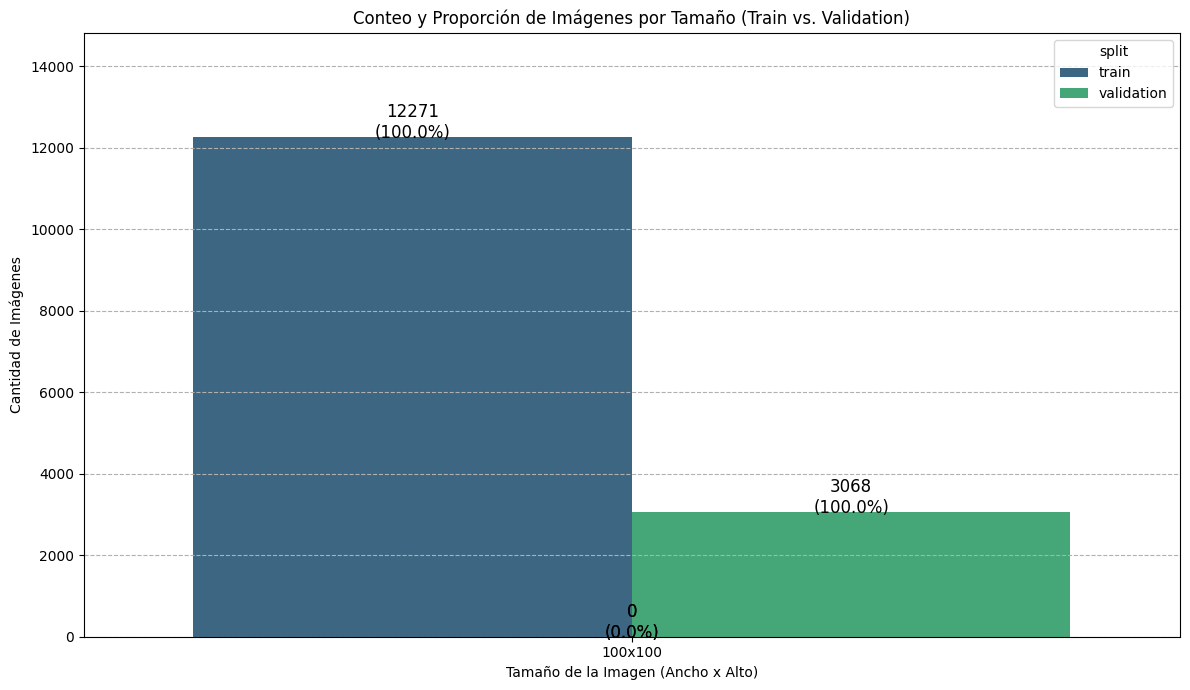

 Analizando Relación de Aspecto (con Porcentajes)...

--- Tabla de Resumen de Relación de Aspecto ---
        split  aspect_ratio  count  percentage
0       train           1.0  12271       100.0
1  validation           1.0   3068       100.0
-----------------------------------------------


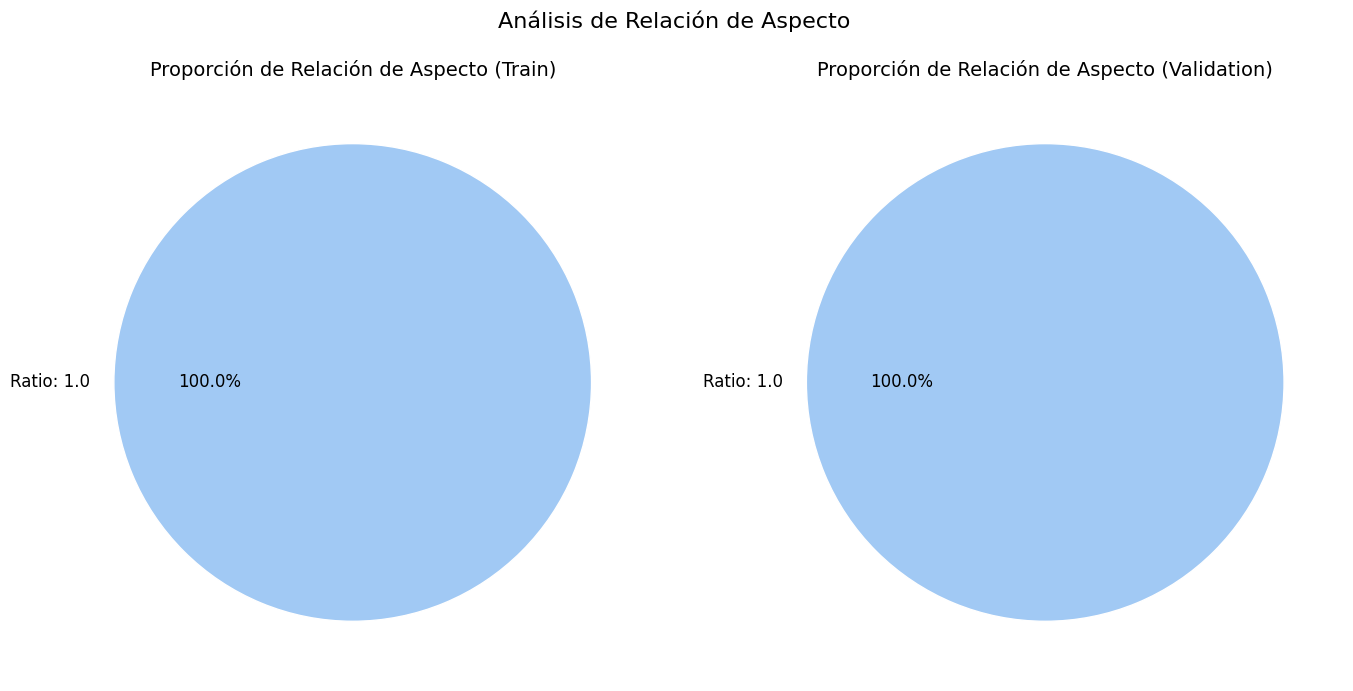

 Analizando Modos de Color (con Porcentajes)...

--- Tabla de Resumen de Modos de Color ---
        split mode  count  percentage
0       train  RGB  12271       100.0
1       train    L      0         0.0
2  validation  RGB   3068       100.0
3  validation    L      0         0.0
------------------------------------------


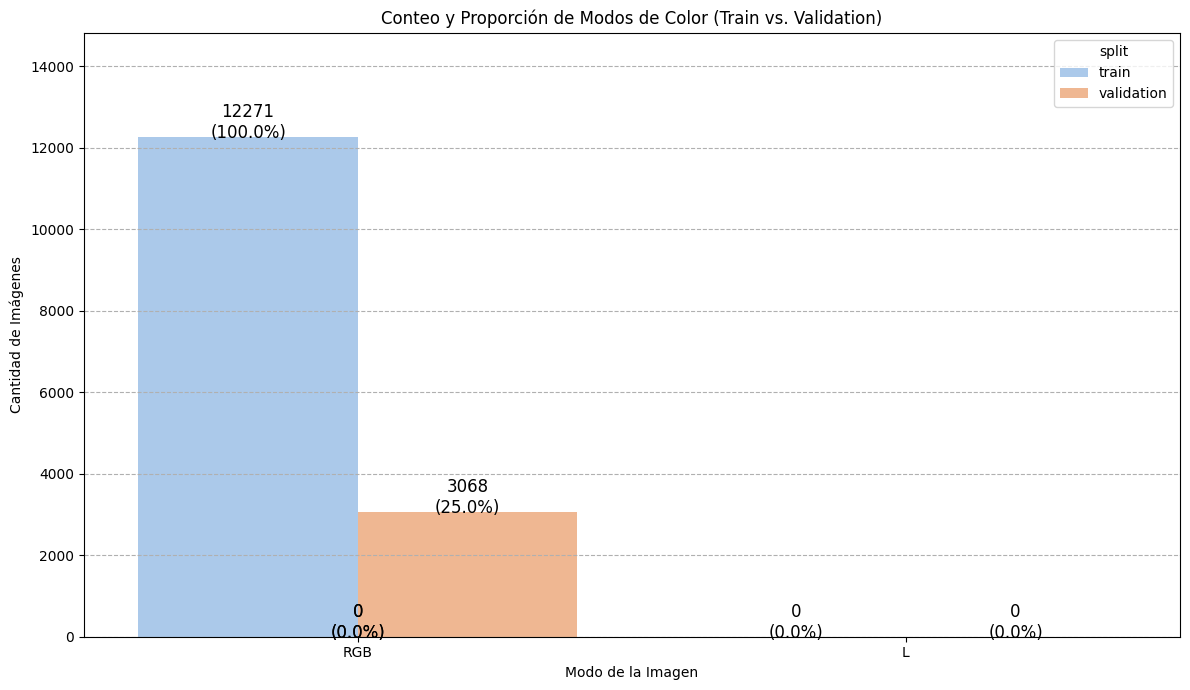


 Analizando Distribución de Píxeles (Muestra de 50 imágenes)...


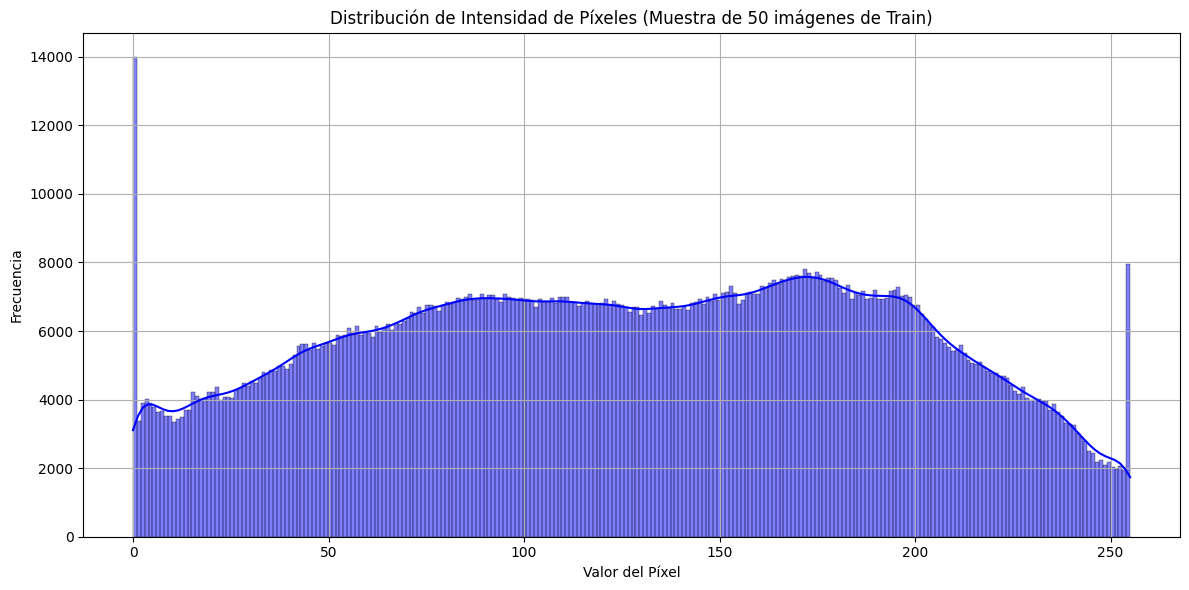


 Analizando Balance de Clases...


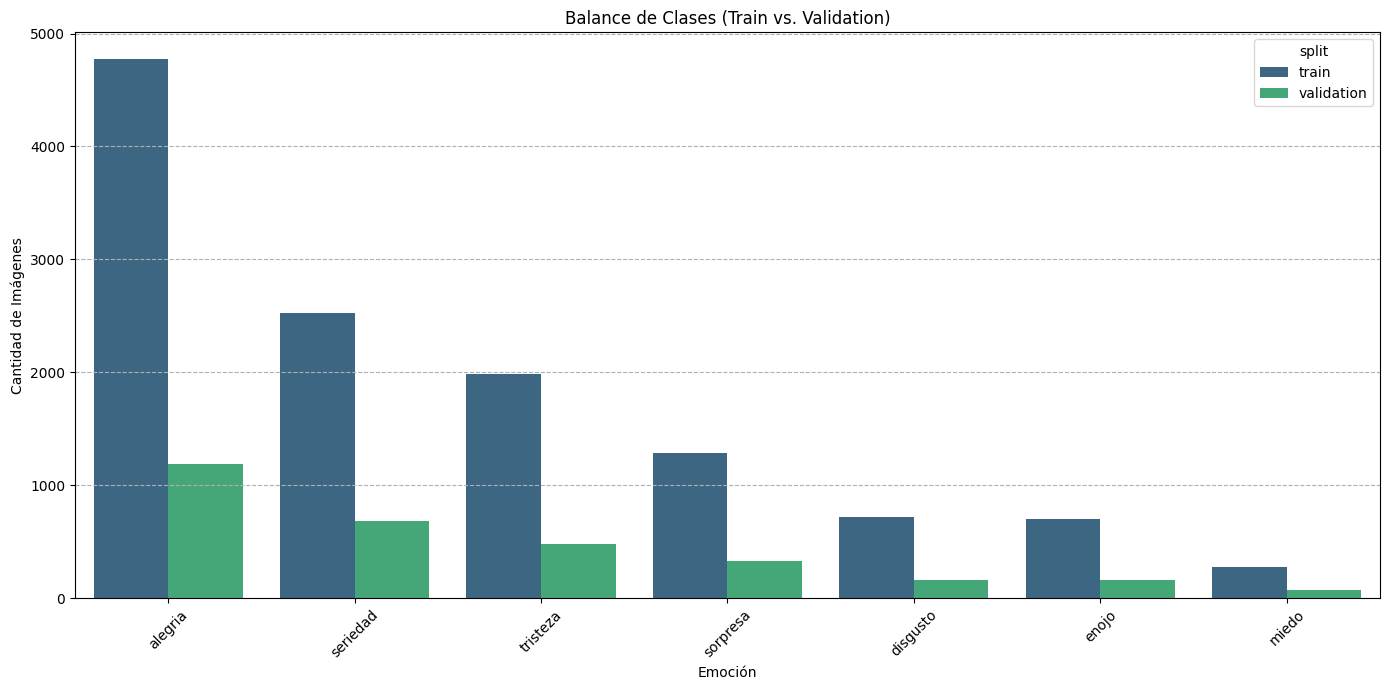


 Visualizando Data Augmentation...


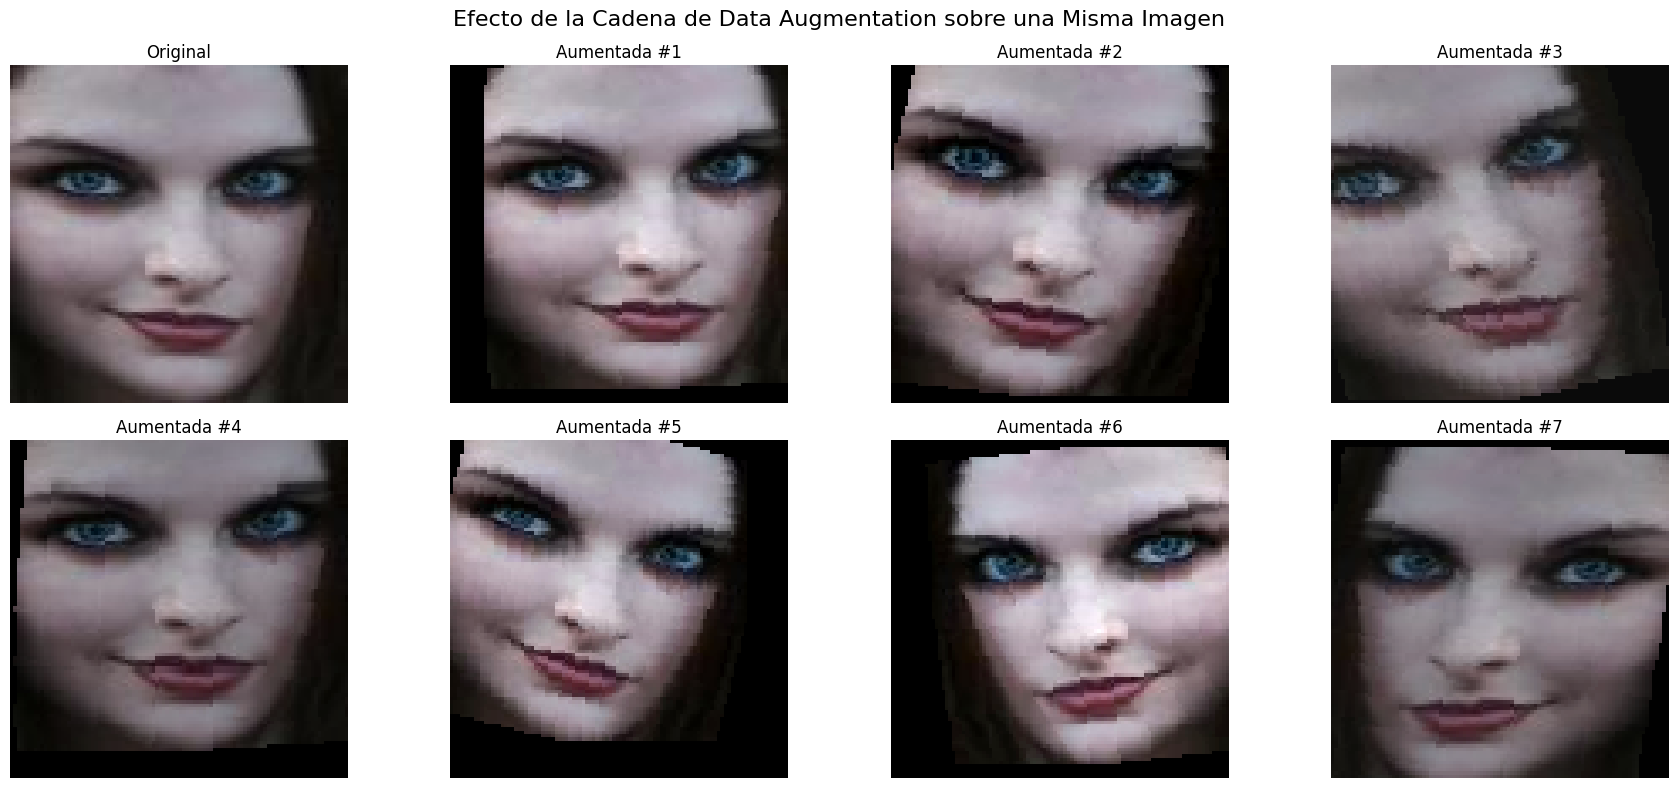

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import random
from itertools import product # Importar product

# --- Configuración ---
base_dir = './dataset_emociones'

# --- 1. FUNCIÓN DE ANÁLISIS ---
def analizar_dataset_completo(base_path):
    splits = {'train': os.path.join(base_path, 'train'), 'validation': os.path.join(base_path, 'validation')}
    all_data = []
    for split_name, directory_path in splits.items():
        if not os.path.exists(directory_path):
            print(f"Advertencia: El directorio no existe, se omitirá: {directory_path}")
            continue
        print(f"Procesando directorio: {directory_path}...")
        emotions = sorted(os.listdir(directory_path))
        for emotion in emotions:
            emotion_path = os.path.join(directory_path, emotion)
            if not os.path.isdir(emotion_path): continue
            for img_file in os.listdir(emotion_path):
                try:
                    with Image.open(os.path.join(emotion_path, img_file)) as img:
                        width, height = img.size
                        all_data.append({
                            'split': split_name, 'emotion': emotion, 'width': width, 'height': height,
                            'aspect_ratio': width / height if height > 0 else 0, 'mode': img.mode,
                            'filepath': os.path.join(emotion_path, img_file)
                        })
                except Exception as e:
                    print(f"No se pudo leer la imagen {img_file}: {e}")
    return pd.DataFrame(all_data)

# --- 2. FUNCIONES DE VISUALIZACIÓN ---

def analizar_y_mostrar_tamanos(df):
    print(" Analizando Tamaños de Imagen (con Porcentajes)...")
    total_counts_per_split = df['split'].value_counts()
    size_summary = df.groupby(['split', 'width', 'height']).size().reset_index(name='count')
    size_summary['percentage'] = (size_summary['count'] / size_summary['split'].map(total_counts_per_split) * 100).round(2)
    print("\n--- Tabla de Resumen de Tamaños (con Porcentajes) ---")
    print(size_summary)
    print("-----------------------------------------------------")
    df['size_str'] = df['width'].astype(str) + 'x' + df['height'].astype(str)
    plt.figure(figsize=(12, 7))
    ax = sns.countplot(data=df, x='size_str', hue='split', palette='viridis')
    hue_order = [label.get_text() for label in ax.get_legend().get_texts()]
    for i, p in enumerate(ax.patches):
        split_name = hue_order[i % len(hue_order)]
        total = total_counts_per_split[split_name]
        count = int(p.get_height())
        percentage = f'{(100 * count / total):.1f}%' if total > 0 else '0.0%'
        label = f'{count}\n({percentage})'
        ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 10), textcoords='offset points')
    plt.title('Conteo y Proporción de Imágenes por Tamaño (Train vs. Validation)')
    plt.xlabel('Tamaño de la Imagen (Ancho x Alto)')
    plt.ylabel('Cantidad de Imágenes')
    ax.set_ylim(0, ax.get_ylim()[1] * 1.15)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

def analizar_relacion_aspecto(df):
    print(" Analizando Relación de Aspecto (con Porcentajes)...")
    total_counts_per_split = df['split'].value_counts()
    summary = df.groupby(['split', 'aspect_ratio']).size().reset_index(name='count')
    summary['percentage'] = (summary['count'] / summary['split'].map(total_counts_per_split) * 100).round(2)
    print("\n--- Tabla de Resumen de Relación de Aspecto ---")
    print(summary)
    print("-----------------------------------------------")
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    splits = ['train', 'validation']
    colors = sns.color_palette('pastel')
    for i, split in enumerate(splits):
        ax = axs[i]
        split_df = df[df['split'] == split]
        data_pie = split_df['aspect_ratio'].value_counts()
        labels_pie = [f'Ratio: {ratio}' for ratio in data_pie.index]
        ax.pie(data_pie, labels=labels_pie, autopct='%1.1f%%',
               wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
               textprops={'fontsize': 12}, colors=colors)
        ax.set_title(f'Proporción de Relación de Aspecto ({split.capitalize()})', fontsize=14)
    fig.suptitle('Análisis de Relación de Aspecto', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def analyze_color_modes(df):
    """
    (NUEVA VERSIÓN)
    Analiza modos de color, asegurando que tanto 'RGB' como 'L' (gris) se muestren,
    e incluye una tabla y un gráfico de barras con porcentajes.
    """
    print(" Analizando Modos de Color (con Porcentajes)...")
    # ---  Crear una tabla de resumen completa ---
    splits = df['split'].unique()
    modes = ['RGB', 'L'] # 'L' es el modo para escala de grises en PIL
    all_combos = pd.DataFrame(list(product(splits, modes)), columns=['split', 'mode'])
    actual_counts = df.groupby(['split', 'mode']).size().reset_index(name='count')
    summary = pd.merge(all_combos, actual_counts, on=['split', 'mode'], how='left')
    summary['count'] = summary['count'].fillna(0).astype(int)
    total_counts_per_split = df['split'].value_counts()
    summary['percentage'] = (summary['count'] / summary['split'].map(total_counts_per_split) * 100).round(2)
    print("\n--- Tabla de Resumen de Modos de Color ---")
    print(summary)
    print("------------------------------------------")
    # ---  Visualización con barplot ---
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=summary, x='mode', y='count', hue='split', palette='pastel')
    hue_order = [label.get_text() for label in ax.get_legend().get_texts()]
    for i, p in enumerate(ax.patches):
        split_name = hue_order[i % len(hue_order)]
        total = total_counts_per_split.get(split_name, 0)
        count = int(p.get_height())
        percentage = f'{(100 * count / total):.1f}%' if total > 0 else '0.0%'
        label = f'{count}\n({percentage})'
        ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 10), textcoords='offset points')
    plt.title('Conteo y Proporción de Modos de Color (Train vs. Validation)')
    plt.xlabel('Modo de la Imagen')
    plt.ylabel('Cantidad de Imágenes')
    ax.set_ylim(0, ax.get_ylim()[1] * 1.15)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

def analizar_distribucion_pixeles(df, sample_size=50):
    print(f"\n Analizando Distribución de Píxeles (Muestra de {sample_size} imágenes)...")
    pixel_values = []
    train_df = df[df['split'] == 'train']
    if len(train_df) < sample_size: sample_size = len(train_df)
    sample_df = train_df.sample(sample_size, random_state=42)
    for filepath in sample_df['filepath']:
        with Image.open(filepath) as img:
            pixel_values.extend(np.array(img).flatten())
    plt.figure(figsize=(12, 6))
    sns.histplot(pixel_values, bins=256, kde=True, color='blue')
    plt.title(f'Distribución de Intensidad de Píxeles (Muestra de {sample_size} imágenes de Train)')
    plt.xlabel('Valor del Píxel')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_class_balance(df):
    print("\n Analizando Balance de Clases...")
    plt.figure(figsize=(14, 7))
    sns.countplot(data=df, x='emotion', hue='split', palette='viridis',
                  order=df['emotion'].value_counts().index)
    plt.title('Balance de Clases (Train vs. Validation)')
    plt.xlabel('Emoción')
    plt.ylabel('Cantidad de Imágenes')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

def visualizar_data_augmentation(df):
    print("\n Visualizando Data Augmentation...")
    sample_img_path = df[(df['emotion'] == 'alegria') & (df['split'] == 'train')].iloc[0]['filepath']
    original_img = Image.open(sample_img_path)
    if original_img.mode != 'RGB': original_img = original_img.convert("RGB")
    augmentation_pipeline = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2)
    ])
    fig, axs = plt.subplots(2, 4, figsize=(18, 8))
    axs[0, 0].imshow(original_img); axs[0, 0].set_title('Original'); axs[0, 0].axis('off')
    for i in range(1, 8):
        ax = axs.flat[i]
        augmented_img = augmentation_pipeline(original_img)
        ax.imshow(augmented_img); ax.set_title(f'Aumentada #{i}'); ax.axis('off')
    plt.suptitle("Efecto de la Cadena de Data Augmentation sobre una Misma Imagen", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN DEL SCRIPT ---
if __name__ == "__main__":
    full_df = analizar_dataset_completo(base_dir)
    if not full_df.empty:
        analizar_y_mostrar_tamanos(full_df)
        analizar_relacion_aspecto(full_df)
        analyze_color_modes(full_df)
        analizar_distribucion_pixeles(full_df)
        plot_class_balance(full_df)
        visualizar_data_augmentation(full_df)
    else:
        print("\nEl DataFrame está vacío. Revisa la ruta en la variable 'base_dir'.")
        print(f"La ruta actual es: {os.path.abspath(base_dir)}")

# Análisis de Preprocesamiento de Datos para Clasificación de Emociones

Para el preprocesamiento de las imágenes, se seleccionaron las siguientes técnicas basándose en un análisis exploratorio del dataset y en las mejores prácticas para el entrenamiento de redes convolucionales (CNNs). El objetivo es estandarizar los datos, mejorar la eficiencia del entrenamiento y aumentar la capacidad de generalización del modelo.

---

### 1. Tamaño y Relación de Aspecto

* **Acción**: Redimensionar todas las imágenes a un tamaño fijo y cuadrado de 48x48 píxeles.
* **Justificación**: Este es un paso **obligatorio**, ya que las arquitecturas de CNN requieren que todas las entradas de un lote (batch) tengan dimensiones idénticas. Se estandariza a un tamaño cuadrado para que la red aprenda patrones espaciales de manera consistente. Forzar este tamaño, utilizando un método de interpolación que preserve las características, permite que el modelo aprenda de forma sistemática la disposición de los rasgos faciales (distancia entre ojos, forma de la boca) que definen una emoción.

---

### 2. Color o Escala de Grises

* **Acción**: Convertir todas las imágenes a escala de grises.
* **Justificación**: Esta es una decisión **criteriosa y fundamental**. La emoción se manifiesta en la **estructura y forma** de los rasgos faciales, no en su color. Al convertir a escala de grises (de 3 canales a 1), se logra:
    1.  **Reducir la complejidad y el costo computacional**, acelerando el entrenamiento.
    2.  **Disminuir el riesgo de *overfitting***, al tener el modelo menos parámetros que aprender.
    3.  **Forzar al modelo a ser más robusto**, ya que aprende a ignorar variaciones irrelevantes como la iluminación o el tono de piel, centrándose en los patrones estructurales que realmente transmiten la emoción.

---

### 3. Cambio de Dimensionalidad

* **Acción**: Reordenar las dimensiones de la imagen del formato HWC (Alto, Ancho, Canales) al formato CHW (Canales, Alto, Ancho).
* **Justificación**: Se trata de un **requisito técnico indispensable** de PyTorch. Sus capas convolucionales están optimizadas para operar sobre tensores en formato CHW. La transformación `torchvision.transforms.ToTensor()` se encarga de realizar esta permutación de ejes de forma automática.

---

### 4. Normalización

* **Acción**: Estandarizar los valores de los píxeles para que tengan una media de 0 y una desviación estándar de 1.
* **Justificación**: La normalización es un paso **esencial** para un entrenamiento estable y eficiente. Aunque `ToTensor()` ya escala los píxeles al rango `[0, 1]`, la normalización posterior centra la distribución de datos en cero. Esto asegura un flujo de gradientes más homogéneo durante el *backpropagation*, lo que acelera la convergencia del optimizador y previene problemas como la saturación de las funciones de activación.

---

### 5. Balanceo de Datos

* **Acción**: Aplicar una técnica de sobremuestreo ponderado, como `WeightedRandomSampler`, durante la carga de los datos de entrenamiento.
* **Justificación**: El análisis exploratorio reveló un **fuerte desbalance de clases**. Ignorar este desbalance provocaría que el modelo desarrolle un sesgo hacia las clases mayoritarias, prediciéndolas con mayor frecuencia para minimizar el error global, pero fallando en las minoritarias. El objetivo es que el modelo sea igualmente competente en la detección de todas las emociones. Al sobremuestrear las clases con menos ejemplos, nos aseguramos de que el modelo vea una representación más equitativa de cada emoción en cada *epoch*, forzándolo a aprender sus características distintivas.

---

### 6. Data Augmentation

* **Acción**: Aplicar transformaciones geométricas aleatorias (volteo horizontal, rotaciones leves) exclusivamente a las imágenes del conjunto de entrenamiento.
* **Justificación**: Es una de las técnicas de regularización **más efectivas para mejorar la generalización** y combatir el *overfitting*. La idea es enseñarle al modelo a ser invariante a ciertas transformaciones que no alteran la etiqueta de la emoción. Por ejemplo, una cara feliz sigue siéndolo aunque esté reflejada horizontalmente o ligeramente inclinada. Estas transformaciones enriquecen artificialmente el dataset, exponiendo al modelo a una mayor variabilidad y preparándolo mejor para los datos del mundo real.

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn



# --- Configuración ---
IMG_SIZE = 100
BASE_DIR = './dataset_emociones'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
BATCH_SIZE = 128

# --- DataLoader Temporal
temp_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor() # Convierte a [0, 1]
])

try:
    temp_dataset = ImageFolder(root=TRAIN_DIR, transform=temp_transforms)
    temp_loader = DataLoader(dataset=temp_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Bucle de Cálculo ---
    mean = 0.
    std = 0.
    num_samples = 0.


    for images, _ in temp_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_samples

    dataset_mean = mean / num_samples
    dataset_std = std / num_samples

except FileNotFoundError:
    print(f"ERROR: No se encontró el directorio de entrenamiento en '{TRAIN_DIR}'.")

DATASET_MEAN = dataset_mean.item()
DATASET_STD = dataset_std.item()

# --- Rutas ---
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'validation')

# --- Transformaciones con Normalización Precisa ---
train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.RandomEqualize(p=0.5),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD]),
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD])
])

# --- Datasets y DataLoaders
train_dataset = ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = ImageFolder(root=VAL_DIR, transform=val_transforms)
CLASS_NAMES = train_dataset.classes

class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"DataLoaders creados con normalización precisa (Mean={DATASET_MEAN:.4f}, Std={DATASET_STD:.4f}).")

DataLoaders creados con normalización precisa (Mean=0.4816, Std=0.1928).


## 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

In [ ]:

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7, conv_channels=[32, 64, 128], kernel_size=3, padding=1,
                 dropout_rate=0.5, activation_fn=nn.ReLU, img_size=48):
        super(EmotionCNN, self).__init__()

        # Extractor de Características Dinámico
        layers = []
        in_channels = 1
        for out_channels in conv_channels:
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                activation_fn(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels
        self.features = nn.Sequential(*layers)

        # Cálculo Robusto del Tamaño Aplanado para evitar errores de dimensión
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, img_size, img_size)
            flattened_features = self.features(dummy_input).flatten().shape[0]

        # Clasificador (con tamaño de entrada calculado automáticamente)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_features, 128),
            activation_fn(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

In [ ]:
!pip install -q torchinfo
!pip install -q torchmetrics

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# ===================================================================
#                PANEL DE CONTROL DE HIPERPARÁMETROS
# ===================================================================
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
OPTIMIZER_CHOICE = 'adamw'
EARLY_STOPPING_PATIENCE = 10
CONV_CHANNELS = [32, 64, 128, 256, 512]
KERNEL_SIZE = 3
PADDING = "same"
DROPOUT_RATE = 0.3
ACTIVATION_CHOICE = 'leaky_relu'
# ===================================================================

# --- Diccionarios y Componentes ---
activation_functions = {'relu': nn.ReLU, 'leaky_relu': nn.LeakyReLU, 'gelu': nn.GELU, 'tanh': nn.Tanh}
optimizer_classes = {'adam': optim.Adam, 'adamw': optim.AdamW, 'sgd': optim.SGD}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(
    num_classes=len(CLASS_NAMES), conv_channels=CONV_CHANNELS, kernel_size=KERNEL_SIZE,
    padding=PADDING, dropout_rate=DROPOUT_RATE,
    activation_fn=activation_functions[ACTIVATION_CHOICE], img_size=IMG_SIZE
).to(device)
optimizer = optimizer_classes[OPTIMIZER_CHOICE](model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- Resumen de la Arquitectura ---
print("--- Arquitectura del Modelo Generada ---")
summary(model, input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))
print("="*80)

# --- Métricas e Historial ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}
best_val_loss, patience_counter = np.inf, 0

# --- Bucle de Entrenamiento ---
print(f" Iniciando entrenamiento en {device}...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0.0
    y_true_train, y_pred_train = [], []
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        y_pred_train.extend(preds.cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())

    model.eval()
    running_val_loss, y_true_val, y_pred_val = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            y_pred_val.extend(preds.cpu().numpy())
            y_true_val.extend(labels.cpu().numpy())

    # --- Cálculo de métricas ---
    train_loss = running_train_loss / len(train_loader.sampler)
    val_loss = running_val_loss / len(val_loader.dataset)
    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    train_f1 = f1_score(y_true_train, y_pred_train, average='macro', zero_division=0)
    val_f1 = f1_score(y_true_val, y_pred_val, average='macro', zero_division=0)

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1); history['val_f1'].append(val_f1)

    status_msg = ""
    if val_loss < best_val_loss:
        best_val_loss, patience_counter = val_loss, 0
        torch.save(model.state_dict(), 'best_model.pth')
        status_msg = "-> ¡Mejora! Modelo guardado."
    else:
        patience_counter += 1
        status_msg = f"-> Paciencia: {patience_counter}/{EARLY_STOPPING_PATIENCE}"

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | {status_msg}")

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n Parada anticipada."); break

print(" Entrenamiento finalizado.")
model.load_state_dict(torch.load('best_model.pth'))
print("Mejor modelo cargado y listo para evaluar.")


--- Arquitectura del Modelo Generada ---
 Iniciando entrenamiento en cuda...


Epoch 1/100 | Train Loss: 1.8081 | Val Loss: 1.4676 | Train Acc: 0.2794 | Val Acc: 0.5469 | Train F1: 0.2755 | Val F1: 0.4162 | -> ¡Mejora! Modelo guardado.


Epoch 2/100 | Train Loss: 1.5616 | Val Loss: 1.1695 | Train Acc: 0.4054 | Val Acc: 0.6203 | Train F1: 0.4032 | Val F1: 0.5047 | -> ¡Mejora! Modelo guardado.


Epoch 3/100 | Train Loss: 1.3695 | Val Loss: 1.0279 | Train Acc: 0.4828 | Val Acc: 0.6545 | Train F1: 0.4826 | Val F1: 0.5287 | -> ¡Mejora! Modelo guardado.


Epoch 4/100 | Train Loss: 1.2525 | Val Loss: 0.9817 | Train Acc: 0.5275 | Val Acc: 0.6698 | Train F1: 0.5241 | Val F1: 0.6094 | -> ¡Mejora! Modelo guardado.


Epoch 5/100 | Train Loss: 1.1781 | Val Loss: 0.9464 | Train Acc: 0.5594 | Val Acc: 0.6776 | Train F1: 0.5574 | Val F1: 0.5962 | -> ¡Mejora! Modelo guardado.


Epoch 6/100 | Train Loss: 1.0871 | Val Loss: 1.0026 | Train Acc: 0.5928 | Val Acc: 0.6535 | Train F1: 0.5912 | Val F1: 0.5886 | -> Paciencia: 1/10


Epoch 7/100 | Train Loss: 1.0076 | Val Loss: 0.7976 | Train Acc: 0.6366 | Val Acc: 0.7236 | Train F1: 0.6353 | Val F1: 0.6486 | -> ¡Mejora! Modelo guardado.


Epoch 8/100 | Train Loss: 0.9656 | Val Loss: 1.0094 | Train Acc: 0.6484 | Val Acc: 0.6379 | Train F1: 0.6462 | Val F1: 0.5321 | -> Paciencia: 1/10


Epoch 9/100 | Train Loss: 0.9241 | Val Loss: 0.9265 | Train Acc: 0.6625 | Val Acc: 0.6747 | Train F1: 0.6626 | Val F1: 0.5992 | -> Paciencia: 2/10


Epoch 10/100 | Train Loss: 0.8908 | Val Loss: 0.8889 | Train Acc: 0.6766 | Val Acc: 0.6757 | Train F1: 0.6756 | Val F1: 0.5961 | -> Paciencia: 3/10


Epoch 11/100 | Train Loss: 0.8363 | Val Loss: 0.7812 | Train Acc: 0.6986 | Val Acc: 0.7200 | Train F1: 0.6980 | Val F1: 0.6455 | -> ¡Mejora! Modelo guardado.


Epoch 12/100 | Train Loss: 0.8082 | Val Loss: 0.8719 | Train Acc: 0.7082 | Val Acc: 0.6894 | Train F1: 0.7074 | Val F1: 0.6011 | -> Paciencia: 1/10


Epoch 13/100 | Train Loss: 0.7717 | Val Loss: 0.6739 | Train Acc: 0.7219 | Val Acc: 0.7647 | Train F1: 0.7209 | Val F1: 0.6794 | -> ¡Mejora! Modelo guardado.


Epoch 14/100 | Train Loss: 0.7438 | Val Loss: 0.7716 | Train Acc: 0.7290 | Val Acc: 0.7314 | Train F1: 0.7279 | Val F1: 0.6316 | -> Paciencia: 1/10


Epoch 15/100 | Train Loss: 0.7338 | Val Loss: 0.7708 | Train Acc: 0.7369 | Val Acc: 0.7301 | Train F1: 0.7360 | Val F1: 0.6510 | -> Paciencia: 2/10


Epoch 16/100 | Train Loss: 0.7018 | Val Loss: 0.6884 | Train Acc: 0.7462 | Val Acc: 0.7686 | Train F1: 0.7459 | Val F1: 0.6816 | -> Paciencia: 3/10


Epoch 17/100 | Train Loss: 0.7002 | Val Loss: 0.7382 | Train Acc: 0.7448 | Val Acc: 0.7487 | Train F1: 0.7445 | Val F1: 0.6608 | -> Paciencia: 4/10


Epoch 18/100 | Train Loss: 0.6692 | Val Loss: 0.6931 | Train Acc: 0.7589 | Val Acc: 0.7621 | Train F1: 0.7587 | Val F1: 0.6707 | -> Paciencia: 5/10


Epoch 19/100 | Train Loss: 0.6601 | Val Loss: 0.7192 | Train Acc: 0.7635 | Val Acc: 0.7389 | Train F1: 0.7639 | Val F1: 0.6612 | -> Paciencia: 6/10


Epoch 20/100 | Train Loss: 0.6478 | Val Loss: 0.6504 | Train Acc: 0.7703 | Val Acc: 0.7859 | Train F1: 0.7710 | Val F1: 0.7095 | -> ¡Mejora! Modelo guardado.


Epoch 21/100 | Train Loss: 0.6085 | Val Loss: 0.6742 | Train Acc: 0.7796 | Val Acc: 0.7640 | Train F1: 0.7800 | Val F1: 0.6910 | -> Paciencia: 1/10


Epoch 22/100 | Train Loss: 0.6026 | Val Loss: 0.6714 | Train Acc: 0.7864 | Val Acc: 0.7683 | Train F1: 0.7864 | Val F1: 0.6864 | -> Paciencia: 2/10


Epoch 23/100 | Train Loss: 0.6124 | Val Loss: 0.6772 | Train Acc: 0.7785 | Val Acc: 0.7709 | Train F1: 0.7768 | Val F1: 0.6959 | -> Paciencia: 3/10


Epoch 24/100 | Train Loss: 0.5891 | Val Loss: 0.6471 | Train Acc: 0.7841 | Val Acc: 0.7774 | Train F1: 0.7839 | Val F1: 0.6968 | -> ¡Mejora! Modelo guardado.


Epoch 25/100 | Train Loss: 0.5709 | Val Loss: 0.6746 | Train Acc: 0.7967 | Val Acc: 0.7771 | Train F1: 0.7958 | Val F1: 0.6990 | -> Paciencia: 1/10


Epoch 26/100 | Train Loss: 0.5659 | Val Loss: 0.6906 | Train Acc: 0.7999 | Val Acc: 0.7627 | Train F1: 0.7992 | Val F1: 0.6810 | -> Paciencia: 2/10


Epoch 27/100 | Train Loss: 0.5552 | Val Loss: 0.7110 | Train Acc: 0.8005 | Val Acc: 0.7683 | Train F1: 0.8002 | Val F1: 0.6865 | -> Paciencia: 3/10


Epoch 28/100 | Train Loss: 0.5535 | Val Loss: 0.8559 | Train Acc: 0.8028 | Val Acc: 0.7122 | Train F1: 0.8029 | Val F1: 0.6523 | -> Paciencia: 4/10


Epoch 29/100 | Train Loss: 0.5521 | Val Loss: 0.6342 | Train Acc: 0.8022 | Val Acc: 0.7950 | Train F1: 0.8023 | Val F1: 0.7071 | -> ¡Mejora! Modelo guardado.


Epoch 30/100 | Train Loss: 0.5361 | Val Loss: 0.7041 | Train Acc: 0.8071 | Val Acc: 0.7800 | Train F1: 0.8076 | Val F1: 0.7055 | -> Paciencia: 1/10


Epoch 31/100 | Train Loss: 0.5334 | Val Loss: 0.6109 | Train Acc: 0.8082 | Val Acc: 0.7999 | Train F1: 0.8081 | Val F1: 0.7124 | -> ¡Mejora! Modelo guardado.


Epoch 32/100 | Train Loss: 0.5396 | Val Loss: 0.6943 | Train Acc: 0.8066 | Val Acc: 0.7793 | Train F1: 0.8068 | Val F1: 0.7046 | -> Paciencia: 1/10


Epoch 33/100 | Train Loss: 0.5108 | Val Loss: 0.7231 | Train Acc: 0.8170 | Val Acc: 0.7624 | Train F1: 0.8167 | Val F1: 0.6804 | -> Paciencia: 2/10


Epoch 34/100 | Train Loss: 0.5158 | Val Loss: 0.7451 | Train Acc: 0.8144 | Val Acc: 0.7480 | Train F1: 0.8149 | Val F1: 0.6587 | -> Paciencia: 3/10


Epoch 35/100 | Train Loss: 0.5241 | Val Loss: 0.7540 | Train Acc: 0.8144 | Val Acc: 0.7516 | Train F1: 0.8146 | Val F1: 0.6576 | -> Paciencia: 4/10


Epoch 36/100 | Train Loss: 0.5175 | Val Loss: 0.7298 | Train Acc: 0.8137 | Val Acc: 0.7617 | Train F1: 0.8129 | Val F1: 0.7019 | -> Paciencia: 5/10


Epoch 37/100 | Train Loss: 0.4860 | Val Loss: 0.6926 | Train Acc: 0.8295 | Val Acc: 0.7832 | Train F1: 0.8287 | Val F1: 0.6992 | -> Paciencia: 6/10


Epoch 38/100 | Train Loss: 0.5027 | Val Loss: 0.7313 | Train Acc: 0.8192 | Val Acc: 0.7692 | Train F1: 0.8192 | Val F1: 0.6911 | -> Paciencia: 7/10


Epoch 39/100 | Train Loss: 0.4848 | Val Loss: 0.6151 | Train Acc: 0.8253 | Val Acc: 0.8057 | Train F1: 0.8250 | Val F1: 0.7166 | -> Paciencia: 8/10


Epoch 40/100 | Train Loss: 0.4833 | Val Loss: 0.8503 | Train Acc: 0.8256 | Val Acc: 0.7314 | Train F1: 0.8253 | Val F1: 0.6606 | -> Paciencia: 9/10


Epoch 41/100 | Train Loss: 0.4748 | Val Loss: 0.7223 | Train Acc: 0.8303 | Val Acc: 0.7810 | Train F1: 0.8298 | Val F1: 0.6759 | -> Paciencia: 10/10

 Parada anticipada.
 Entrenamiento finalizado.
Mejor modelo cargado y listo para evaluar.


--- Generando Gráficas de Evolución ---


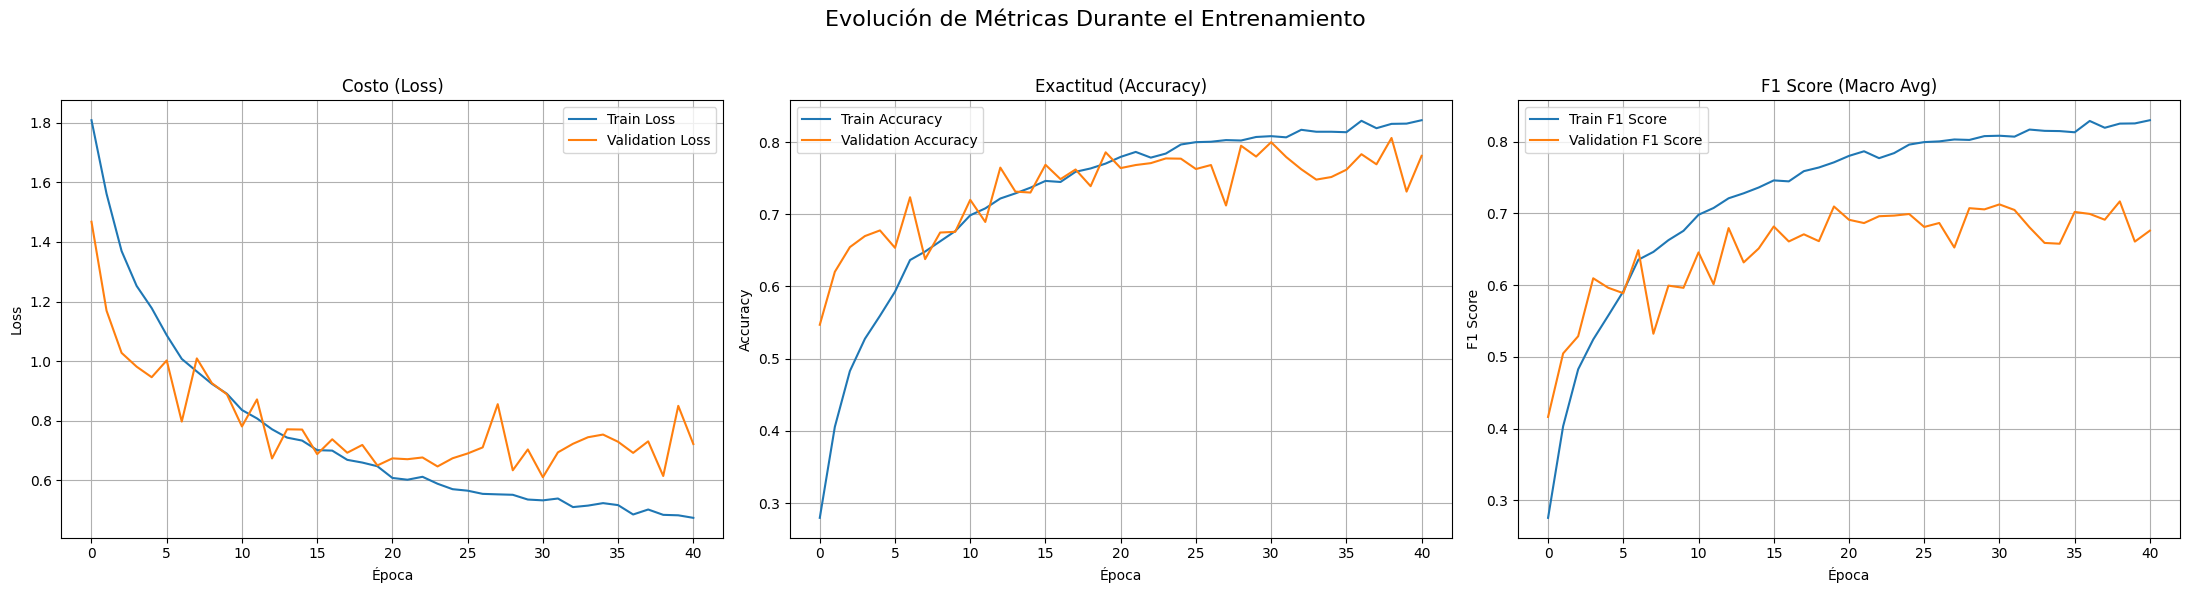


Valor Final en Validación - Accuracy: 0.7810
Valor Final en Validación - F1 Score (Macro Avg): 0.6759

--- Reporte de Clasificación Detallado ---

              precision    recall  f1-score   support

     alegria       0.92      0.89      0.91      1185
    disgusto       0.49      0.55      0.52       160
       enojo       0.71      0.70      0.70       162
       miedo       0.53      0.55      0.54        74
    seriedad       0.77      0.79      0.78       680
    sorpresa       0.82      0.77      0.79       329
    tristeza       0.74      0.76      0.75       478

    accuracy                           0.80      3068
   macro avg       0.71      0.72      0.71      3068
weighted avg       0.80      0.80      0.80      3068



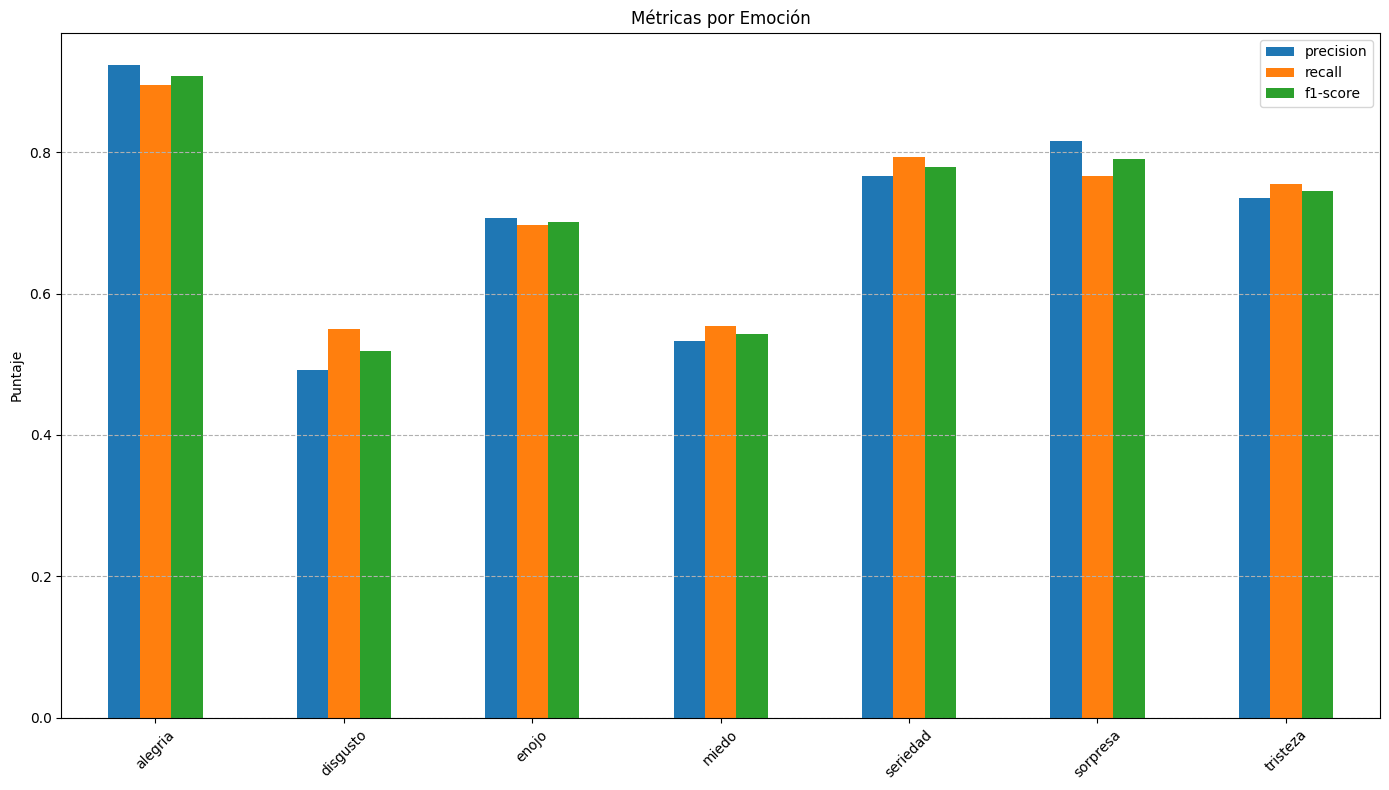


--- Matrices de Confusión ---



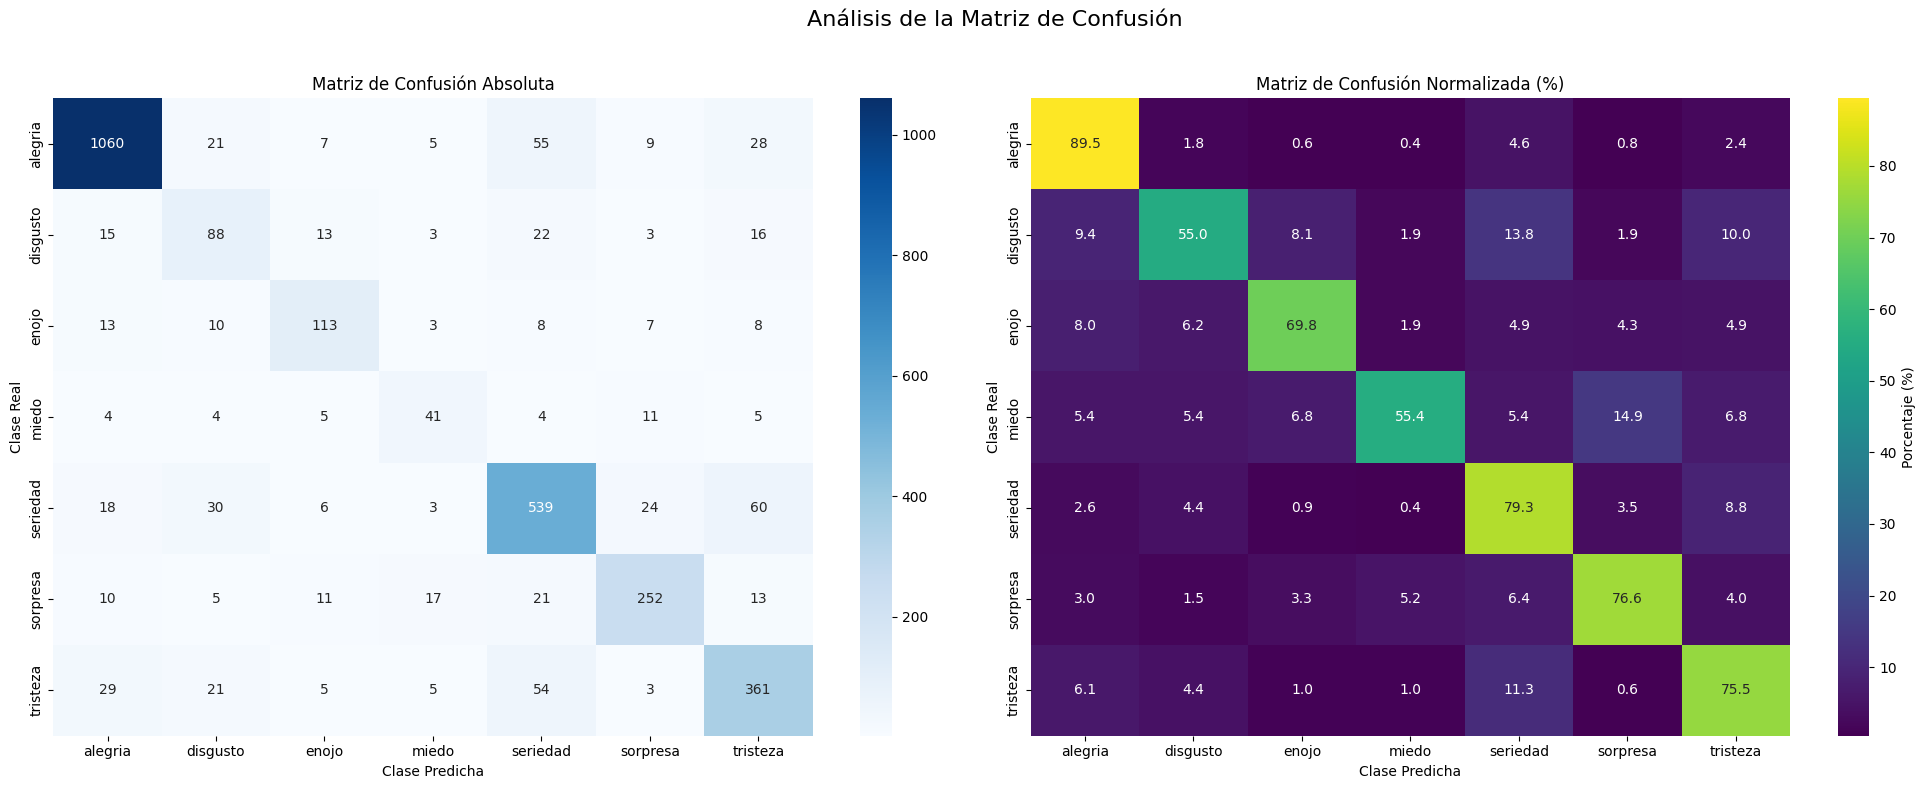

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import torch

# --- Gráficas de Evolución por Época ---
print("--- Generando Gráficas de Evolución ---")

fig, axs = plt.subplots(1, 3, figsize=(22, 6))
plt.suptitle('Evolución de Métricas Durante el Entrenamiento', fontsize=16)

# Gráfica de Costo (Loss)
axs[0].plot(history['train_loss'], label='Train Loss')
axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Costo (Loss)')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Gráfica de Exactitud (Accuracy)
axs[1].plot(history.get('train_acc', []), label='Train Accuracy') # .get para compatibilidad si no se guardó
axs[1].plot(history['val_acc'], label='Validation Accuracy')
axs[1].set_title('Exactitud (Accuracy)')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# Gráfica de F1 Score
axs[2].plot(history.get('train_f1', []), label='Train F1 Score') # .get para compatibilidad
axs[2].plot(history['val_f1'], label='Validation F1 Score')
axs[2].set_title('F1 Score (Macro Avg)')
axs[2].set_xlabel('Época')
axs[2].set_ylabel('F1 Score')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Reportar valor final en validación
print(f"\nValor Final en Validación - Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Valor Final en Validación - F1 Score (Macro Avg): {history['val_f1'][-1]:.4f}")


# --- Función para obtener todas las predicciones ---
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Obtenemos las predicciones y etiquetas reales del conjunto de validación
y_true, y_pred = get_all_predictions(model, val_loader, device)


# -- Reporte de Clasificación (Texto y Gráfico) ---
print("\n" + "="*60 + "\n--- Reporte de Clasificación Detallado ---\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)).transpose()
report_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar', figsize=(14, 8), rot=45)
plt.title('Métricas por Emoción'); plt.ylabel('Puntaje'); plt.grid(axis='y', linestyle='--'); plt.tight_layout(); plt.show()


# --Matrices de Confusión (Lado a Lado) ---
print("\n" + "="*60 + "\n--- Matrices de Confusión ---\n")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Análisis de la Matriz de Confusión', fontsize=16)

# Matriz Absoluta
cm_abs = confusion_matrix(y_true, y_pred)
sns.heatmap(cm_abs, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_title('Matriz de Confusión Absoluta'); axes[0].set_ylabel('Clase Real'); axes[0].set_xlabel('Clase Predicha')

# Matriz Normalizada en Porcentaje
cm_norm = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='viridis', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1], cbar_kws={'label': 'Porcentaje (%)'})
axes[1].set_title('Matriz de Confusión Normalizada (%)'); axes[1].set_ylabel('Clase Real'); axes[1].set_xlabel('Clase Predicha')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

HABKLR DE NECSIDA DE BALANCEO Y PROBAR FOCALLOSS, COLOCAR REFERENCIA NECESARIA

LOS RESULTADOS OBTENIDO SNO SON LO SMEJORES. SE HAE UN ABUSQEUDA DE GRILLA PARA ENCONTRAR MEJORES PARTAMETROS. SE DEJA EN TEXTO POREU SE HIZO LA CORRIDA EN MAQUINALOCAL POQRUE EL TIEMPO DE GPU DISPONIOBLE EN COLAB NO LO PERMITIA. SE DEJA EL CODIGO AUCONTENIDO CON LOS PUNTOS AMODIFICAR EN CASO DE QUE SE QUIERA PROBAR DE FORMA LOCAL

import gdown
import zipfile
import os

# --- Configuración ---
file_id = "1auZ64-CEfa4tx16cVq9TdibsdKwQY9jN"
output_zip = "emotion_dataset.zip"
extract_path = './'

# --- Descarga y Descompresión ---
gdown.download(id=file_id, output=output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# --- Verificación ---
try:
    print(f"\nContenido de '{extract_path}':")
    # Los zips a veces contienen una carpeta raíz, esto lo maneja.
    base_content = os.listdir(extract_path)
    if len(base_content) == 1 and os.path.isdir(os.path.join(extract_path, base_content[0])):
         final_path = os.path.join(extract_path, base_content[0])
         print(f"-> Subcarpeta encontrada: '{base_content[0]}'")
         print(os.listdir(final_path))
    else:
         print(base_content)
except FileNotFoundError:
    print(f"No se pudo encontrar la carpeta '{extract_path}'. Revisa el contenido del zip.")

!pip install -q torchinfo
!pip install -q torchmetrics


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import time

# ===================================================================
#                CONFIGURACIÓN INICIAL DEL EXPERIMENTO
# ===================================================================

#  Define la ruta base a tu dataset (debe contener 'train' y 'validation')
BASE_DIR = './dataset_emociones' # <-- ¡MODIFICA ESTA RUTA!

#  Pega los valores de media y desviación estándar de tu dataset
DATASET_MEAN = 0.48171210289001465
DATASET_STD = 0.19046492874622345

#  Define el tamaño de las imágenes
IMG_SIZE = 100
# ===================================================================

# ---  IMPLEMENTACIÓN DE FOCAL LOSS ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss
        if self.alpha is not None:
            if self.alpha.device != targets.device:
                self.alpha = self.alpha.to(targets.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- ARQUITECTURA DE LA RED ---
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7, conv_channels=[32, 64, 128], kernel_size=3, padding="same",
                 dropout_rate=0.5, activation_fn=nn.ReLU, img_size=48):
        super(EmotionCNN, self).__init__()
        layers = []
        in_channels = 1
        for out_channels in conv_channels:
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                activation_fn(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, img_size, img_size)
            flattened_features = self.features(dummy_input).flatten().shape[0]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_features, 128),
            activation_fn(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

# ---  FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, y_true, y_pred = 0.0, [], []
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    dataset_len = len(dataloader.sampler) if dataloader.sampler else len(dataloader.dataset)
    return running_loss / dataset_len, accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro', zero_division=0)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, y_true, y_pred = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return running_loss / len(dataloader.dataset), accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro', zero_division=0)

# ---  PREPARACIÓN DE DATOS ---
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'validation')
train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.RandomEqualize(p=0.5),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD])
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=val_transforms)
CLASS_NAMES = train_dataset.classes

# ---  GRILLA DE PARÁMETROS Y DICCIONARIOS ---
param_grid = {
    'imbalance_strategy': ['WRS', 'WRS_LS', 'FocalLoss'],
    'learning_rate': [ 0.001, 0.005],
    'batch_size': [128],
    'optimizer': ['AdamW'],
    'dropout_rate': [0.3],
    'activation_fn': ['GELU', 'SiLU'],
    'conv_channels': [[32, 64, 128, 256, 512], [ 32, 64, 128, 256, 512, 1024]],
    'kernel_size': [3, 5]
}
activation_functions = {'GELU': nn.GELU, 'SiLU': nn.SiLU}
optimizer_classes = {'AdamW': optim.AdamW}

# --- 6. BUCLE PRINCIPAL DE BÚSQUEDA EN GRILLA ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

keys, values = zip(*param_grid.items())
hyperparam_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
results = []
NUM_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10 # Aumentado un poco la paciencia

print(f"Iniciando Grid Search con {len(hyperparam_combinations)} combinaciones...")

for i, params in enumerate(hyperparam_combinations):
    start_time = time.time()
    print(f"\n--- Experimento {i+1}/{len(hyperparam_combinations)} ---")
    print(f"Parámetros: {params}")

    if params['imbalance_strategy'] == 'WRS':
        class_counts = np.bincount(train_dataset.targets)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        sample_weights = class_weights[train_dataset.targets]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], sampler=sampler)
        criterion = nn.CrossEntropyLoss()
    elif params['imbalance_strategy'] == 'WRS_LS':
        class_counts = np.bincount(train_dataset.targets)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        sample_weights = class_weights[train_dataset.targets]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], sampler=sampler)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    elif params['imbalance_strategy'] == 'FocalLoss':
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        criterion = FocalLoss(gamma=2.0)
    
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    model = EmotionCNN(num_classes=len(CLASS_NAMES), conv_channels=params['conv_channels'], dropout_rate=params['dropout_rate'], activation_fn=activation_functions[params['activation_fn']], kernel_size=params['kernel_size'], img_size=IMG_SIZE).to(device)
    optimizer = optimizer_classes[params['optimizer']](model.parameters(), lr=params['learning_rate'])
    
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}
    best_val_f1 = -1
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
        
        
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1); history['val_f1'].append(val_f1)
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Paciencia: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
            
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Parada anticipada en la época {epoch+1}")
            break
            
    end_time = time.time()
    result = params.copy()
    result['final_val_f1'] = best_val_f1
    result['final_val_acc'] = val_acc
    result['total_epochs'] = epoch + 1
    result['duration_sec'] = end_time - start_time
    result['history'] = history # <-- CAMBIO CLAVE 3: Guardar el historial completo
    results.append(result)

print("Búsqueda en grilla finalizada.")

# --- 7. ANÁLISIS Y VISUALIZACIÓN DE RESULTADOS ---
results_df = pd.DataFrame(results)

for col in ['conv_channels']:
    results_df[col] = results_df[col].astype(str)
results_df_sorted = results_df.sort_values(by='final_val_f1', ascending=False).reset_index(drop=True)

print("\n--- Mejores 5 Combinaciones de Hiperparámetros ---")

print(results_df_sorted.drop(columns=['history']).head())


print("\n--- Gráficas de Evolución para los 5 Mejores Modelos ---")
for i, row in results_df_sorted.head(5).iterrows():
    history_data = row['history']
    epochs = range(1, len(history_data['train_loss']) + 1)
    
    
    params_str = f"LR: {row['learning_rate']}, Strat: {row['imbalance_strategy']}, Act: {row['activation_fn']}, Kernel: {row['kernel_size']}\nArch: {row['conv_channels']}"

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle(f'Modelo Top {i+1} - F1-Score Final: {row["final_val_f1"]:.4f}\n{params_str}', fontsize=16)

    # Gráfica de Costo (Loss)
    axes[0].plot(epochs, history_data['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history_data['val_loss'], 'orange', label='Validation Loss')
    axes[0].set_title('Costo (Loss)', fontweight='bold')
    axes[0].set_xlabel('Época', fontweight='bold')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfica de Exactitud (Accuracy)
    axes[1].plot(epochs, history_data['train_acc'], 'b-', label='Train Accuracy')
    axes[1].plot(epochs, history_data['val_acc'], 'orange', label='Validation Accuracy')
    axes[1].set_title('Exactitud (Accuracy)', fontweight='bold')
    axes[1].set_xlabel('Época', fontweight='bold')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Gráfica de F1 Score
    axes[2].plot(epochs, history_data['train_f1'], 'b-', label='Train F1 Score')
    axes[2].plot(epochs, history_data['val_f1'], 'orange', label='Validation F1 Score')
    axes[2].set_title('F1 Score (Macro Avg)', fontweight='bold')
    axes[2].set_xlabel('Época', fontweight='bold')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

Búsqueda en grilla finalizada.

--- Mejores 5 Combinaciones de Hiperparámetros ---

| imbalance_strategy | learning_rate | batch_size | optimizer | dropout_rate | activation_fn | conv_channels | kernel_size | final_val_f1 | final_val_acc | total_epochs | duration_sec |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| WRS_LS | 0.001 | 128 | AdamW | 0.3 | GELU | [32, 64, 128, 256, 512, 1024] | 5 | 0.759137 | 0.822034 | 67 | 1546.574581 |
| WRS_LS | 0.005 | 128 | AdamW | 0.3 | SiLU | [32, 64, 128, 256, 512, 1024] | 3 | 0.754930 | 0.816167 | 74 | 1554.355632 |
| WRS_LS | 0.001 | 128 | AdamW | 0.3 | SiLU | [32, 64, 128, 256, 512, 1024] | 3 | 0.753094 | 0.821056 | 56 | 1161.766301 |
| WRS_LS | 0.001 | 128 | AdamW | 0.3 | GELU | [32, 64, 128, 256, 512, 1024] | 3 | 0.753042 | 0.802803 | 49 | 1011.592499 |
| FocalLoss | 0.001 | 128 | AdamW | 0.3 | GELU | [32, 64, 128, 256, 512] | 5 | 0.751527 | 0.835724 | 60 | 1325.915559 |

In [16]:
from IPython.display import Image, display

url_correcta = 'https://raw.githubusercontent.com/Neo820712/TP-DL/main/gridsearch/output.png'
display(Image(url=url_correcta))
url_correcta2 = 'https://raw.githubusercontent.com/Neo820712/TP-DL/main/gridsearch/output2.png'
display(Image(url=url_correcta2))
url_correcta3 = 'https://raw.githubusercontent.com/Neo820712/TP-DL/main/gridsearch/output3.png'
display(Image(url=url_correcta3))
url_correcta4 = 'https://raw.githubusercontent.com/Neo820712/TP-DL/main/gridsearch/output4.png'
display(Image(url=url_correcta4))
url_correcta5 = 'https://raw.githubusercontent.com/Neo820712/TP-DL/main/gridsearch/output5.png'
display(Image(url=url_correcta5))

a simplevst etenoms buenops resulatdos pero si meiramos la garficas de entreaneminto detectamos algunas cosas importantes de overfitting MEJORA EN EL 5TO MODELO Y LA DIFERENCIA CON EL ACCURACY NO ES SIGNIFICATIVA ASI QEU SE HACE CON ESE Y SE SUBE EL DROUPOT RATE A 5 PARA REDUCIR EL OVERFITTING. sE DEJA TODO EL CODIGO AUTOCONTENIDO APRA SER REPRODUCIBLE SIN TENER QUE CORRER LAS CELDAS DE NETRNAMEINTO ANTERIORES

In [3]:
!pip install -q torchinfo
!pip install -q torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random

# ===================================================================
#                1. CONFIGURACIÓN INICIAL
# ===================================================================
BASE_DIR = './dataset_emociones'
DATASET_MEAN = 0.48171210289001465
DATASET_STD = 0.19046492874622345
IMG_SIZE = 100
# ===================================================================

# --- CLASES Y FUNCIONES AUXILIARES ---

# Arquitectura de la Red
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7, conv_channels=[32, 64, 128], kernel_size=3, padding="same",
                 dropout_rate=0.5, activation_fn=nn.ReLU, img_size=48):
        super(EmotionCNN, self).__init__()
        layers = []
        in_channels = 1
        for out_channels in conv_channels:
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                activation_fn,
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, img_size, img_size)
            try:
                flattened_features = self.features(dummy_input).flatten().shape[0]
            except IndexError:
                raise ValueError(f"La arquitectura {conv_channels} con kernel {kernel_size} es demasiado profunda para un IMG_SIZE de {img_size}.")
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_features, 128),
            activation_fn,
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# Funciones de Entrenamiento y Evaluación
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, y_true, y_pred = 0.0, [], []
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    dataset_len = len(dataloader.sampler)
    return running_loss / dataset_len, accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro', zero_division=0)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, y_true, y_pred = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return running_loss / len(dataloader.dataset), accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro', zero_division=0)


# --- PREPARACIÓN DE DATOS ---
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'validation')
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.TrivialAugmentWide(),
    transforms.RandomEqualize(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD])
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=val_transforms)
CLASS_NAMES = train_dataset.classes



#   HIPERPARÁMETROS DEL MODELO

LEARNING_RATE = 5e-4
DROPOUT_RATE = 0.5
WEIGHT_DECAY = 0.01
BATCH_SIZE = 128
ACTIVATION_FN = nn.GELU()
CONV_CHANNELS = [32, 64, 128, 256, 512, 1024]
KERNEL_SIZE = 5
IMBALANCE_STRATEGY = 'WRS_LS'
NUM_EPOCHS = 150
EARLY_STOPPING_PATIENCE = 20



#  INICIALIZACIÓN Y ENTRENAMIENTO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

model = EmotionCNN(num_classes=len(CLASS_NAMES), conv_channels=CONV_CHANNELS, dropout_rate=DROPOUT_RATE, activation_fn=ACTIVATION_FN, kernel_size=KERNEL_SIZE, img_size=IMG_SIZE).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}
best_val_f1 = -1; patience_counter = 0; best_model_state_dict = None
print("Iniciando entrenamiento del modelo final...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1); history['val_f1'].append(val_f1)

    status_msg = ""
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1; patience_counter = 0; best_model_state_dict = model.state_dict().copy()
        torch.save(best_model_state_dict, 'best_emotion_model.pth')
        status_msg = "-> ¡Mejora! Modelo guardado."
    else:
        patience_counter += 1
        status_msg = f"-> Paciencia: {patience_counter}/{EARLY_STOPPING_PATIENCE}"
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | {status_msg}")
    scheduler.step(val_f1)
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Parada anticipada en la época {epoch+1}"); break
print(" Entrenamiento finalizado.")





Usando dispositivo: cuda
Iniciando entrenamiento del modelo final...
Epoch 1/150 | Val Loss: 1.8231 | Val F1: 0.1736 | -> ¡Mejora! Modelo guardado.
Epoch 2/150 | Val Loss: 1.8348 | Val F1: 0.1516 | -> Paciencia: 1/20
Epoch 3/150 | Val Loss: 1.8199 | Val F1: 0.2079 | -> ¡Mejora! Modelo guardado.
Epoch 4/150 | Val Loss: 1.7566 | Val F1: 0.2996 | -> ¡Mejora! Modelo guardado.
Epoch 5/150 | Val Loss: 1.7318 | Val F1: 0.3049 | -> ¡Mejora! Modelo guardado.
Epoch 6/150 | Val Loss: 1.6074 | Val F1: 0.3796 | -> ¡Mejora! Modelo guardado.
Epoch 7/150 | Val Loss: 1.3915 | Val F1: 0.4528 | -> ¡Mejora! Modelo guardado.
Epoch 8/150 | Val Loss: 1.3943 | Val F1: 0.4433 | -> Paciencia: 1/20
Epoch 9/150 | Val Loss: 1.2782 | Val F1: 0.5378 | -> ¡Mejora! Modelo guardado.
Epoch 10/150 | Val Loss: 1.6293 | Val F1: 0.3731 | -> Paciencia: 1/20
Epoch 11/150 | Val Loss: 1.1857 | Val F1: 0.5573 | -> ¡Mejora! Modelo guardado.
Epoch 12/150 | Val Loss: 1.1412 | Val F1: 0.6053 | -> ¡Mejora! Modelo guardado.
Epoch 13/1

## 3. Evaluación del Modelo (2.5 puntos)

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.



--- ANÁLISIS COMPLETO DEL MEJOR MODELO GUARDADO ---

--- Generando Gráficas de Evolución del Mejor Modelo ---


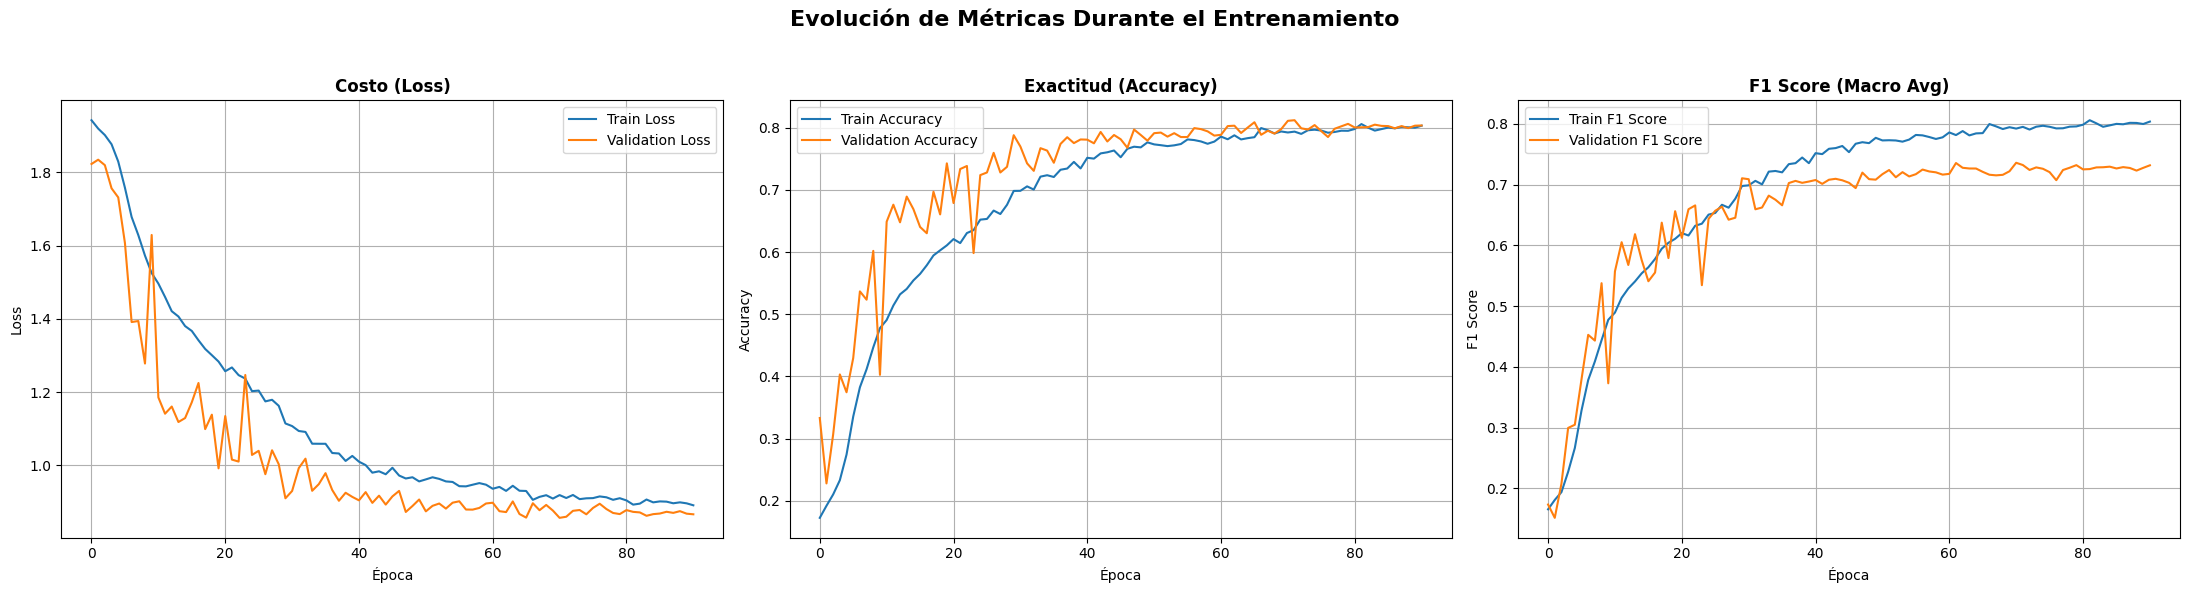


Valor Final en Validación - Accuracy: 0.8038
Valor Final en Validación - F1 Score (Macro Avg): 0.7318

--- Reporte de Clasificación Detallado ---

              precision    recall  f1-score   support

     alegria       0.96      0.85      0.90      1185
    disgusto       0.44      0.61      0.51       160
       enojo       0.68      0.78      0.73       162
       miedo       0.59      0.64      0.61        74
    seriedad       0.80      0.75      0.78       680
    sorpresa       0.76      0.85      0.80       329
    tristeza       0.75      0.82      0.78       478

    accuracy                           0.80      3068
   macro avg       0.71      0.76      0.73      3068
weighted avg       0.82      0.80      0.81      3068



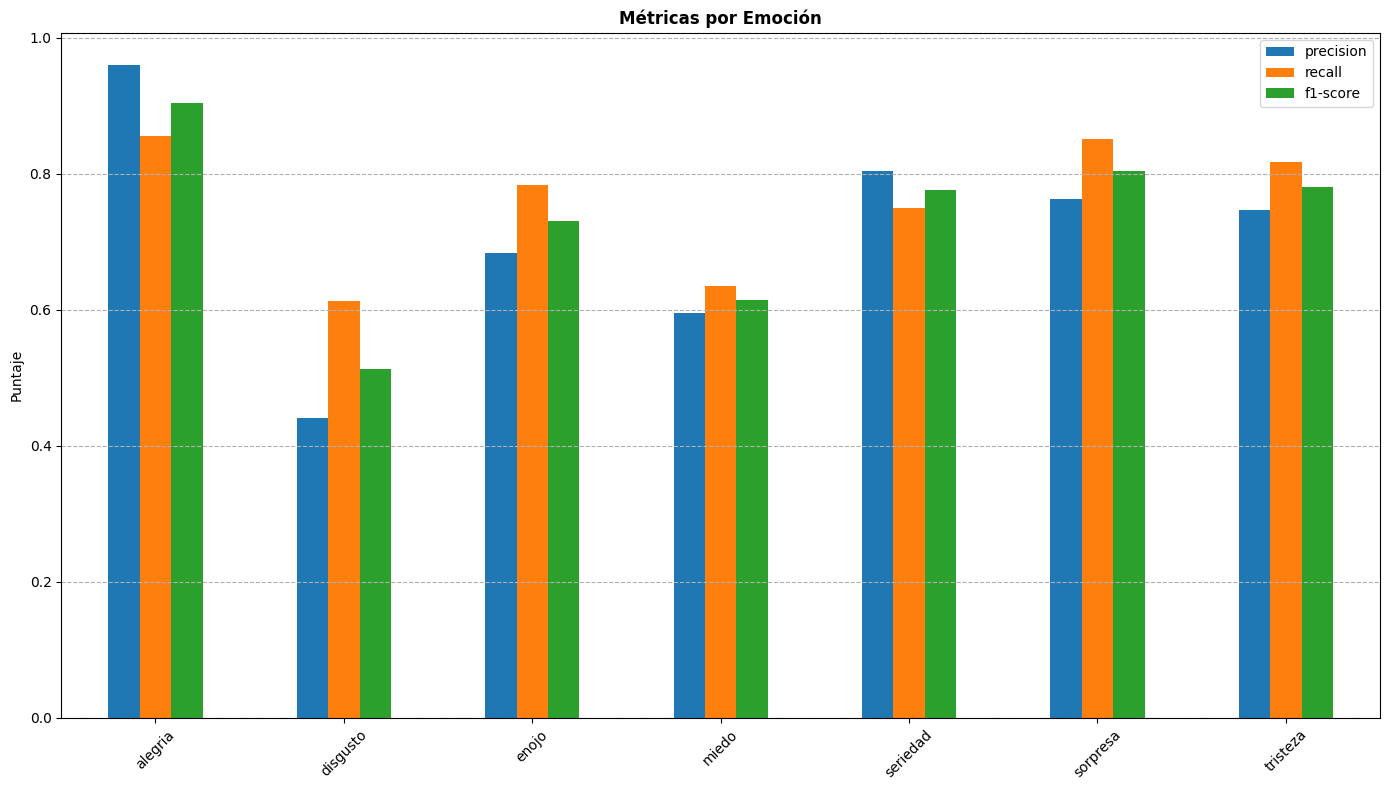


--- Matrices de Confusión ---



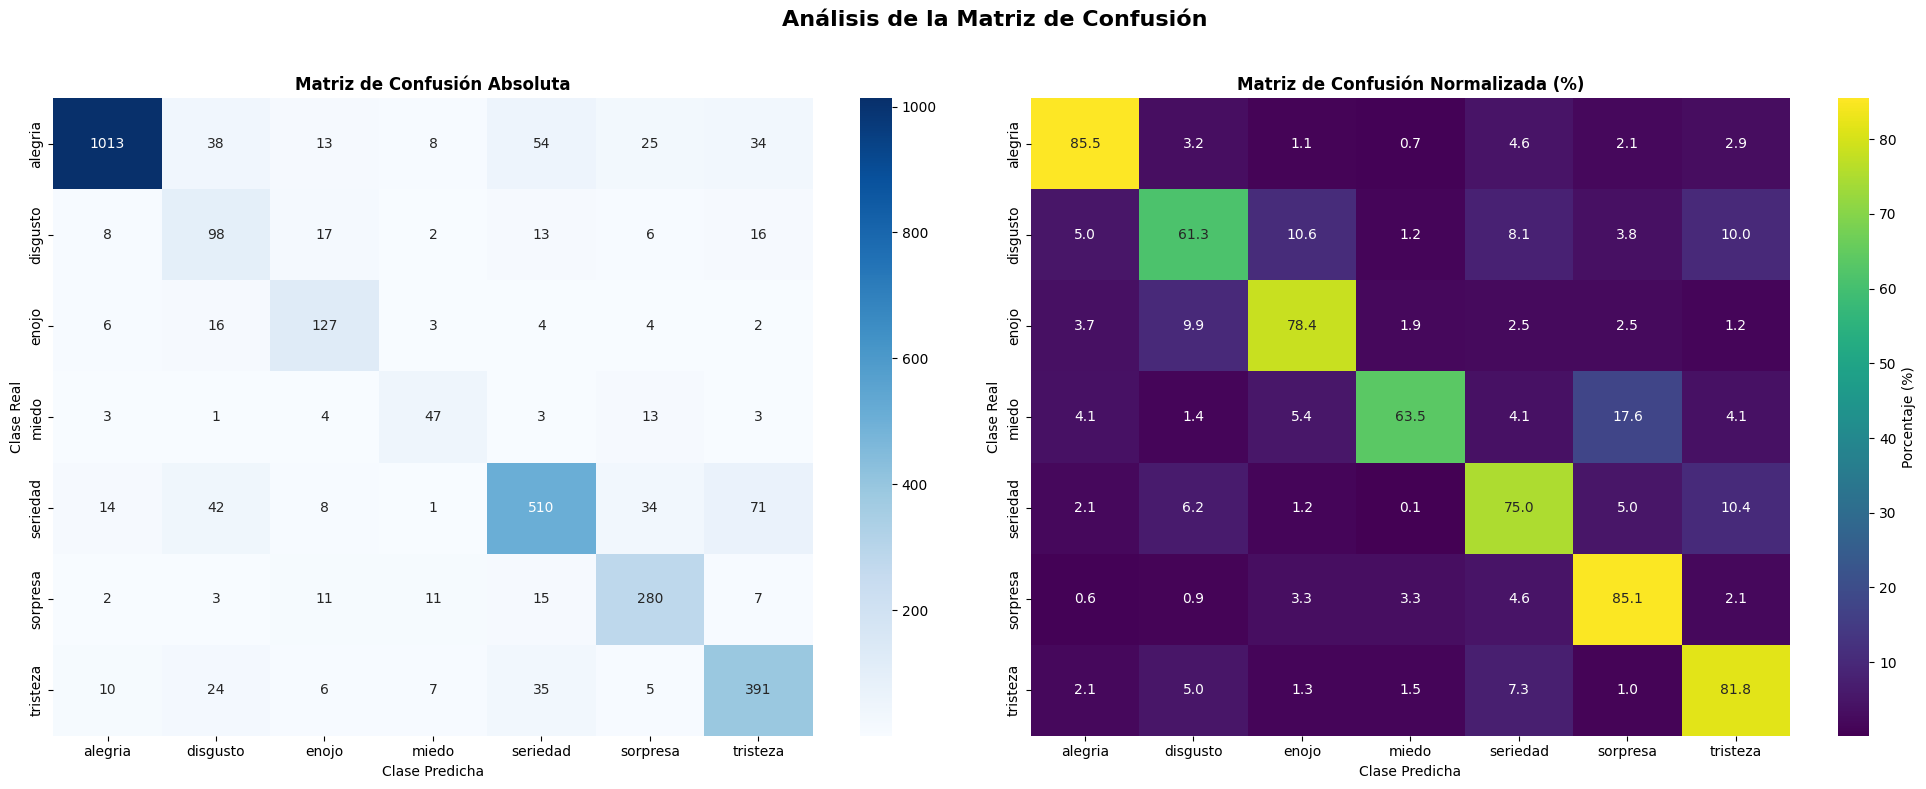


--- ANÁLISIS DE ERRORES: EJEMPLOS MAL CLASIFICADOS ---



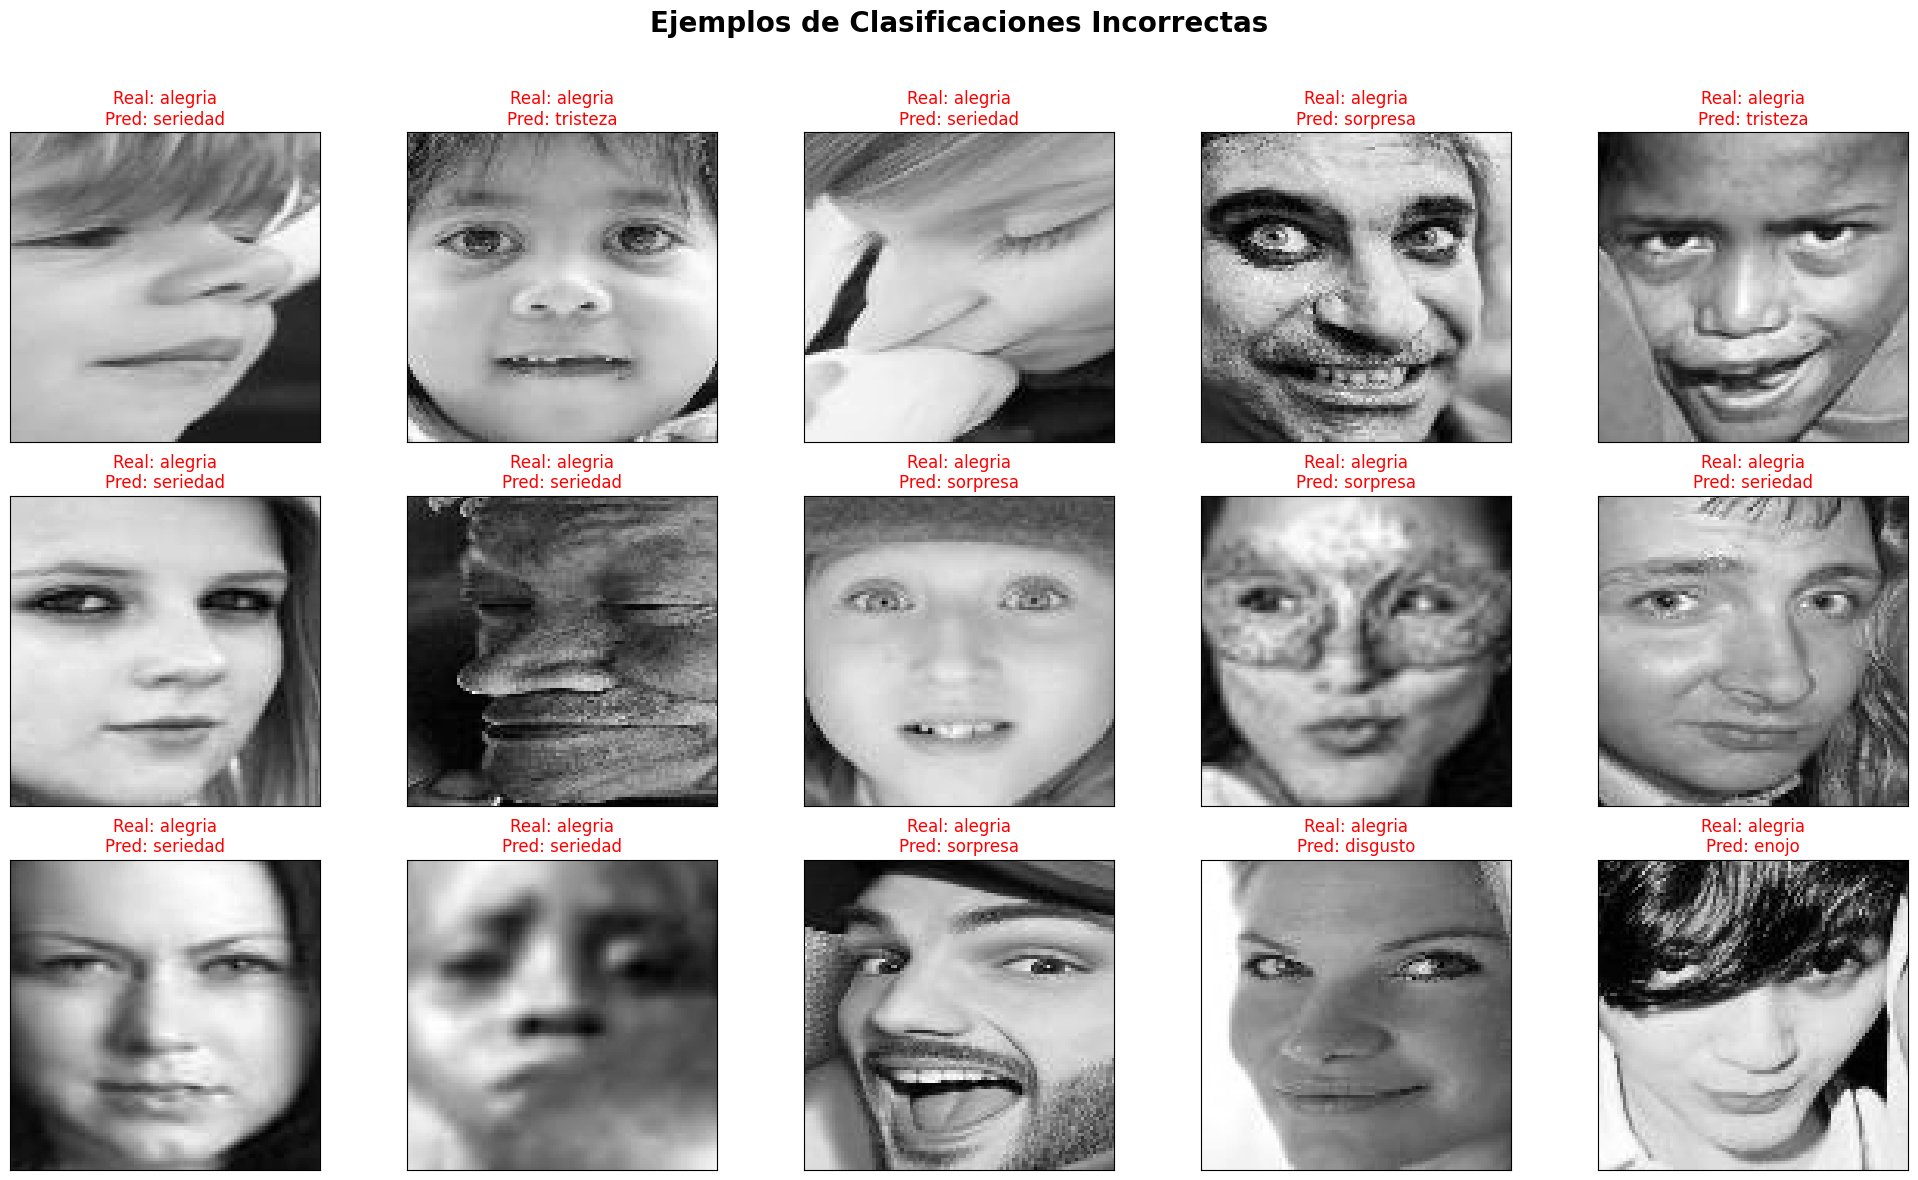

In [4]:
#  EVALUACIÓN FINAL DEL  MODELO

print("\n" + "="*80 + "\n--- ANÁLISIS COMPLETO DEL MEJOR MODELO GUARDADO ---\n")
model.load_state_dict(best_model_state_dict)

# Gráficas de Evolución por Época ---
print("--- Generando Gráficas de Evolución del Mejor Modelo ---")
fig, axs = plt.subplots(1, 3, figsize=(22, 6))
plt.suptitle('Evolución de Métricas Durante el Entrenamiento', fontsize=16, fontweight='bold')
axs[0].plot(history['train_loss'], label='Train Loss'); axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Costo (Loss)', fontweight='bold'); axs[0].set_xlabel('Época'); axs[0].set_ylabel('Loss'); axs[0].legend(); axs[0].grid(True)
axs[1].plot(history['train_acc'], label='Train Accuracy'); axs[1].plot(history['val_acc'], label='Validation Accuracy')
axs[1].set_title('Exactitud (Accuracy)', fontweight='bold'); axs[1].set_xlabel('Época'); axs[1].set_ylabel('Accuracy'); axs[1].legend(); axs[1].grid(True)
axs[2].plot(history['train_f1'], label='Train F1 Score'); axs[2].plot(history['val_f1'], label='Validation F1 Score')
axs[2].set_title('F1 Score (Macro Avg)', fontweight='bold'); axs[2].set_xlabel('Época'); axs[2].set_ylabel('F1 Score'); axs[2].legend(); axs[2].grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

print(f"\nValor Final en Validación - Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Valor Final en Validación - F1 Score (Macro Avg): {history['val_f1'][-1]:.4f}")

# Reporte de Clasificación y Métricas por Clase ---
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_all_predictions(model, val_loader, device)

print("\n" + "="*60 + "\n--- Reporte de Clasificación Detallado ---\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)).transpose()
report_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar', figsize=(14, 8), rot=45)
plt.title('Métricas por Emoción', fontweight='bold'); plt.ylabel('Puntaje'); plt.grid(axis='y', linestyle='--'); plt.tight_layout(); plt.show()

# matrices de Confusión ---
print("\n" + "="*60 + "\n--- Matrices de Confusión ---\n")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Análisis de la Matriz de Confusión', fontsize=16, fontweight='bold')
cm_abs = confusion_matrix(y_true, y_pred)
sns.heatmap(cm_abs, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_title('Matriz de Confusión Absoluta', fontweight='bold'); axes[0].set_ylabel('Clase Real'); axes[0].set_xlabel('Clase Predicha')
cm_norm = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='viridis', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1], cbar_kws={'label': 'Porcentaje (%)'})
axes[1].set_title('Matriz de Confusión Normalizada (%)', fontweight='bold'); axes[1].set_ylabel('Clase Real'); axes[1].set_xlabel('Clase Predicha')
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


# ANÁLISIS DE ERRORES ---
def plot_misclassified(model, loader, class_names, mean, std, n=20):
    print("\n" + "="*80 + "\n--- ANÁLISIS DE ERRORES: EJEMPLOS MAL CLASIFICADOS ---\n")
    model.eval()
    errors = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs_dev, labels_dev = inputs.to(device), labels.to(device)
            outputs = model(inputs_dev)
            preds = torch.argmax(outputs, 1)
            mask = (preds.cpu() != labels)
            if mask.any():
                for i in range(len(mask)):
                    if mask[i]:
                        errors.append((inputs[i], labels[i].item(), preds[i].cpu().item()))
            if len(errors) >= n * 2: break

    unorm = transforms.Normalize(mean=[-mean/std], std=[1/std])
    fig, axes = plt.subplots(int(np.ceil(n/5)), 5, figsize=(20, 4 * int(np.ceil(n/5))))
    fig.suptitle('Ejemplos de Clasificaciones Incorrectas', fontsize=20, fontweight='bold')
    axes = axes.flatten()
    for i, (img_tensor, true_idx, pred_idx) in enumerate(errors[:n]):
        ax = axes[i]
        img = unorm(img_tensor)
        img = img.permute(1, 2, 0)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Real: {class_names[true_idx]}\nPred: {class_names[pred_idx]}", color='red')
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

plot_misclassified(model, val_loader, CLASS_NAMES, DATASET_MEAN, DATASET_STD, n=15)

 ## 4. Prueba de Imágenes Nuevas (1 punto)
Subir al menos 6 imágenes personales de cualquier relación de aspecto (pueden usar fotos del rostro de ustedes, rostros de personas generadas por IA o imágenes stock de internet), que no formen parte del dataset de entrenamiento ni de validación.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo pre-procesamiento que se usó para el dataset durante el entrenamiento del modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Redactar conclusiones preliminares

Modelo 'best_emotion_model.pth' cargado y en modo de evaluación.


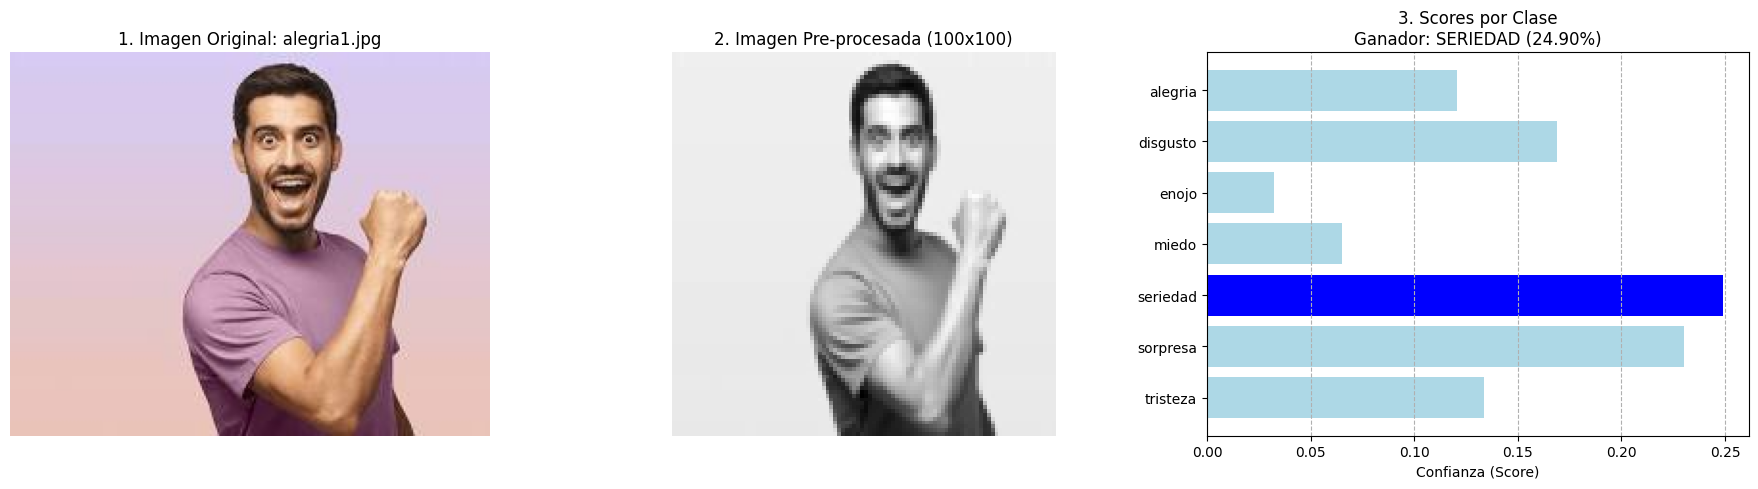

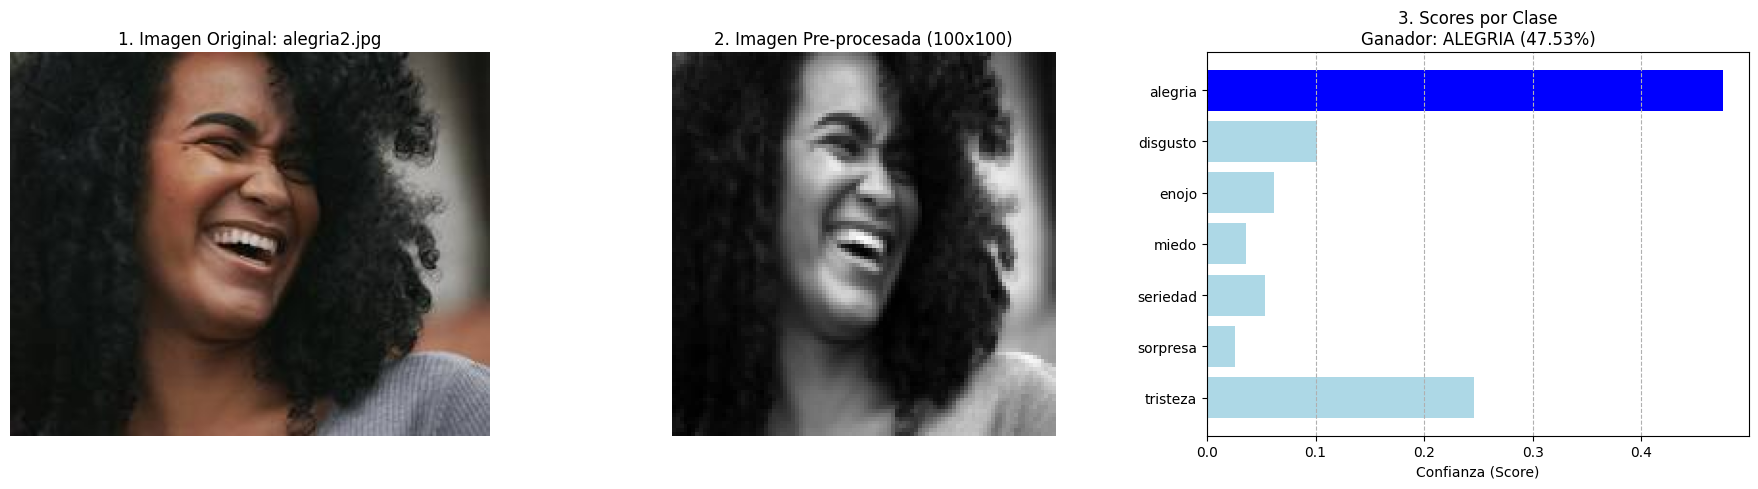

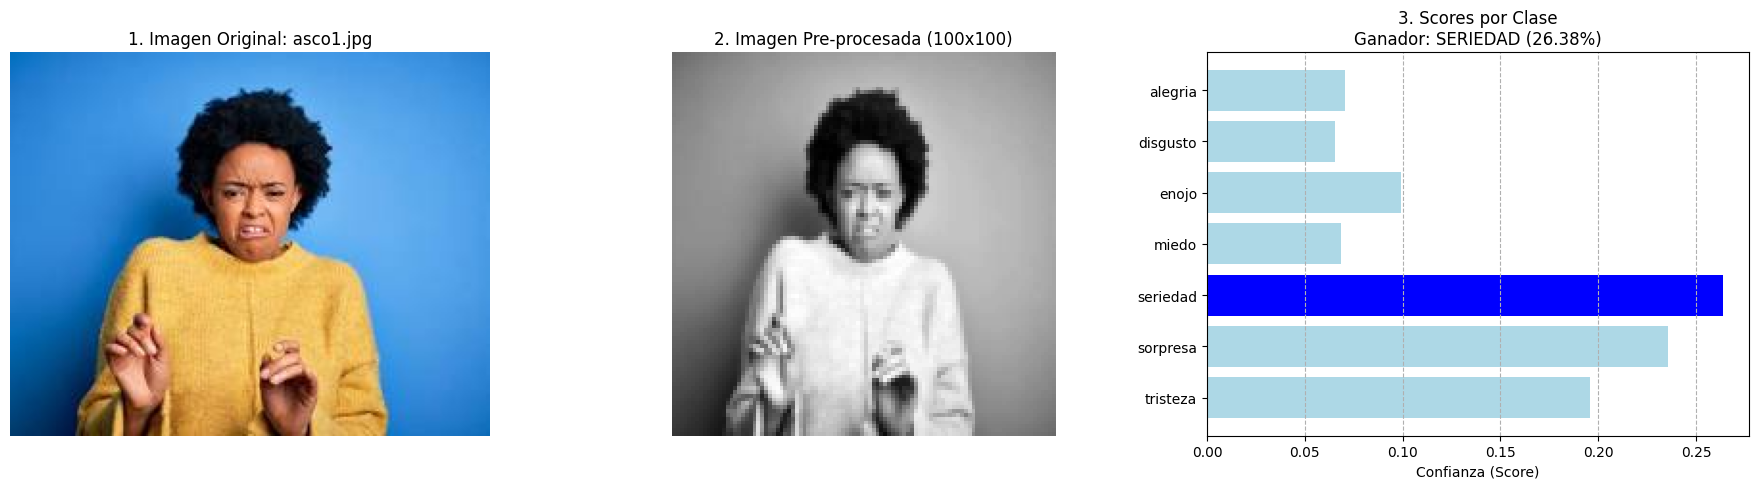

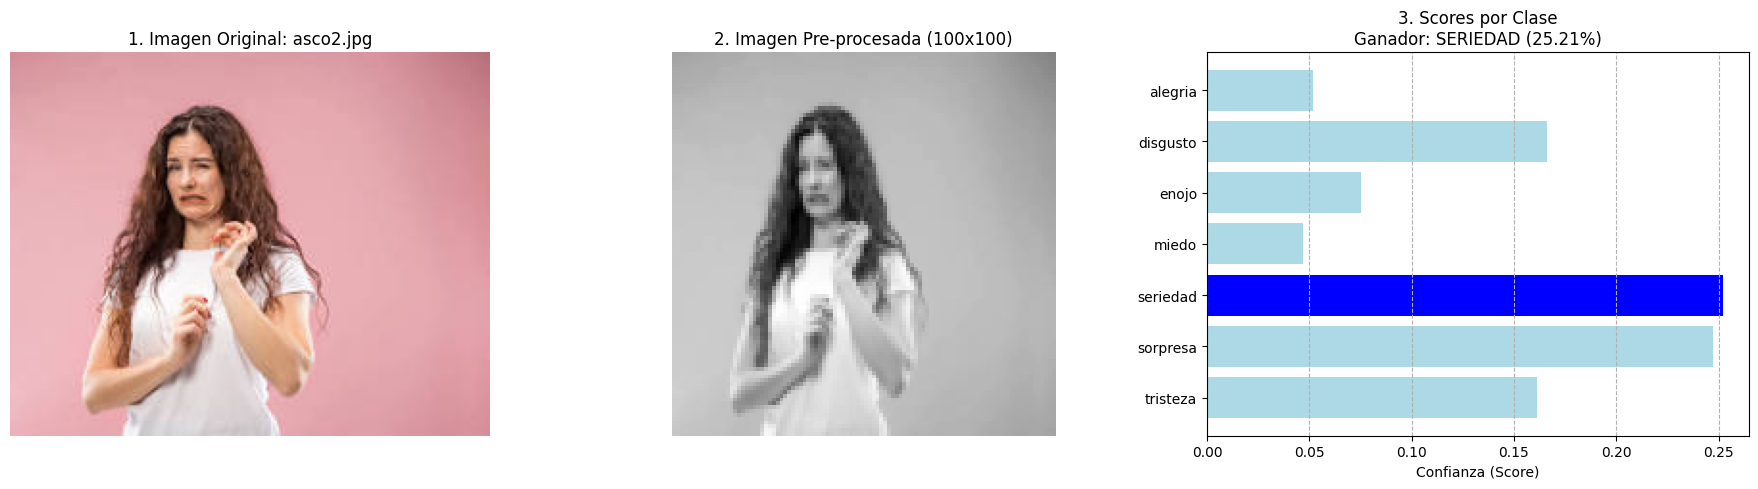

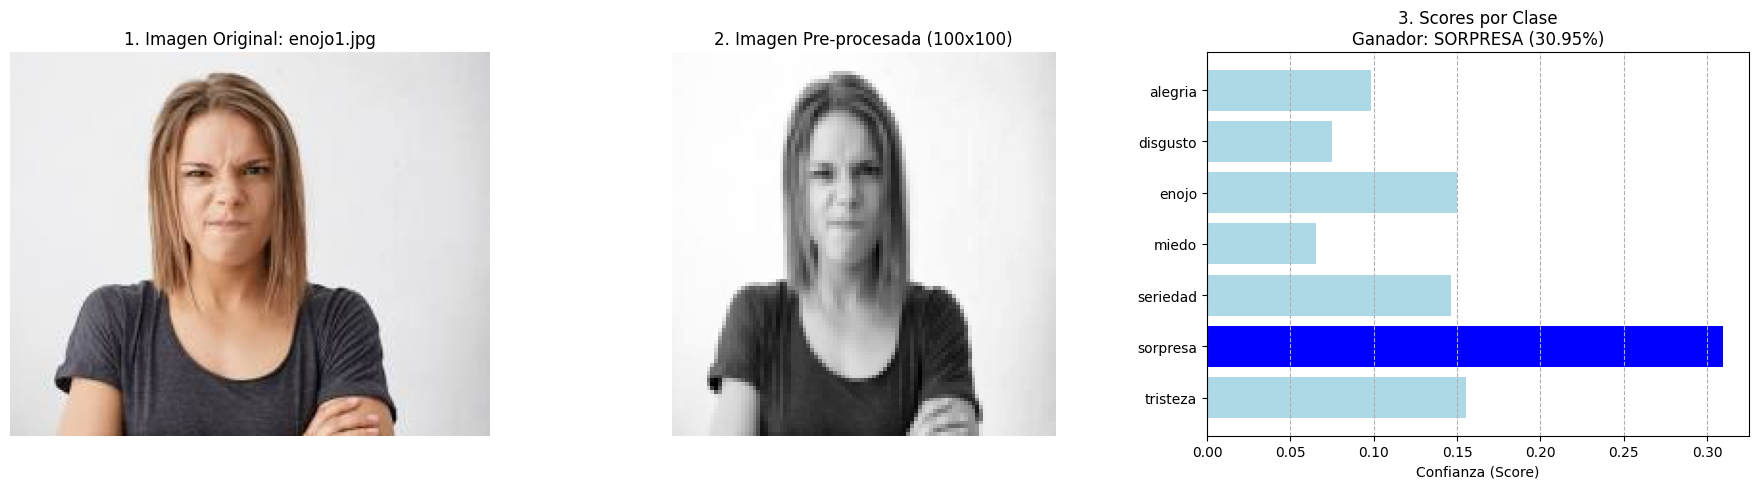

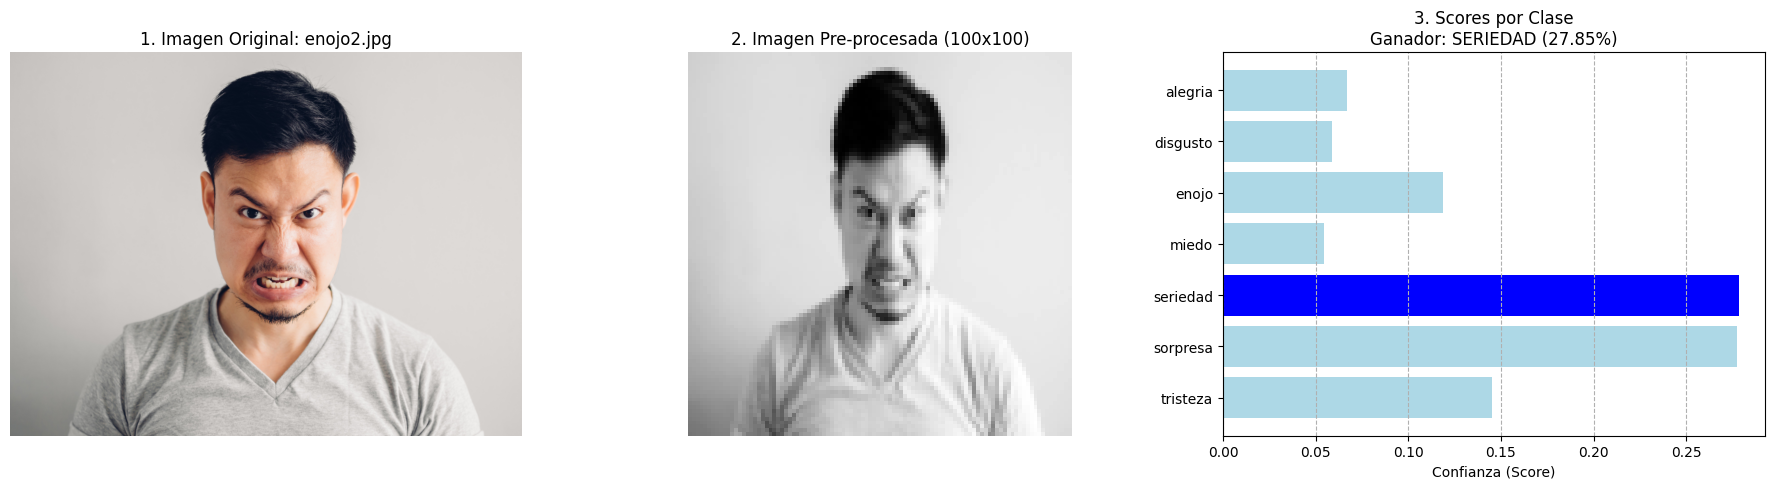

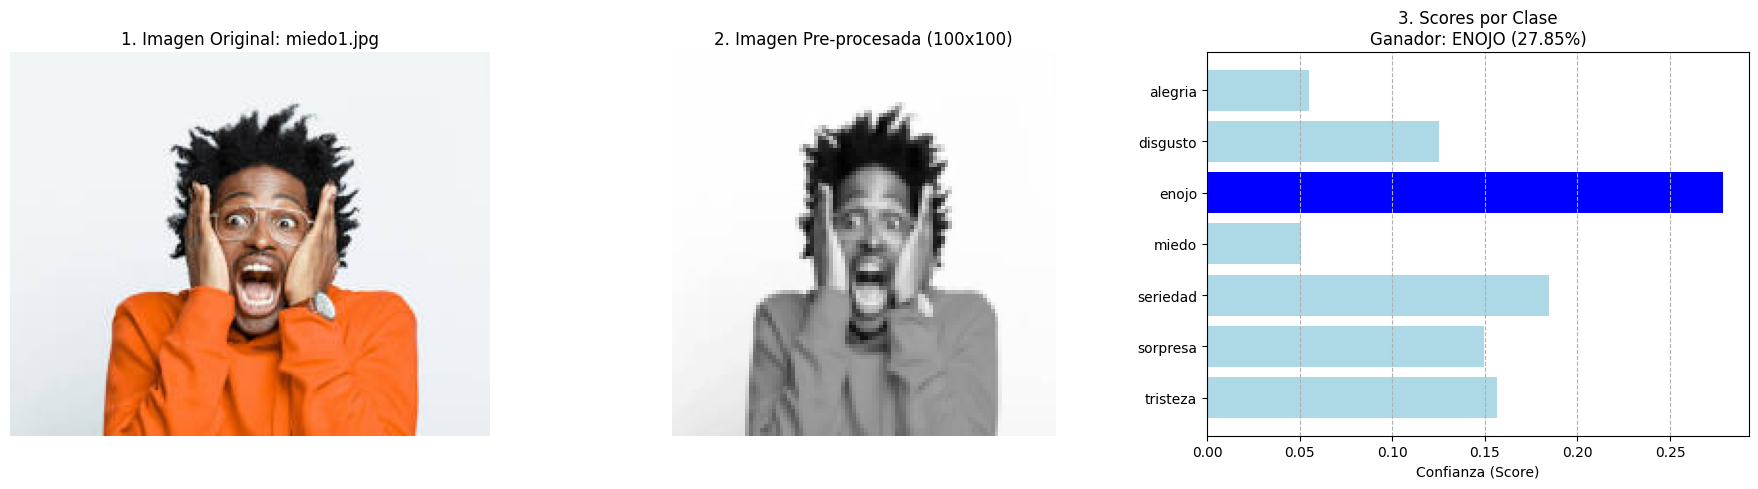

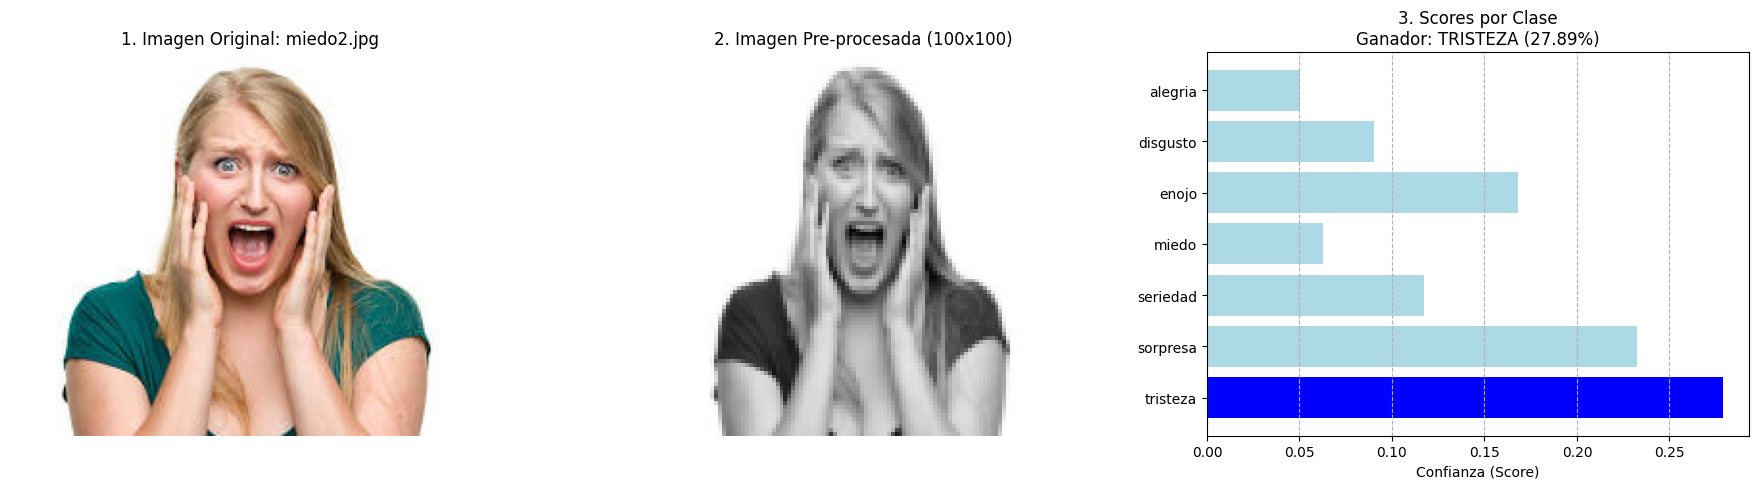

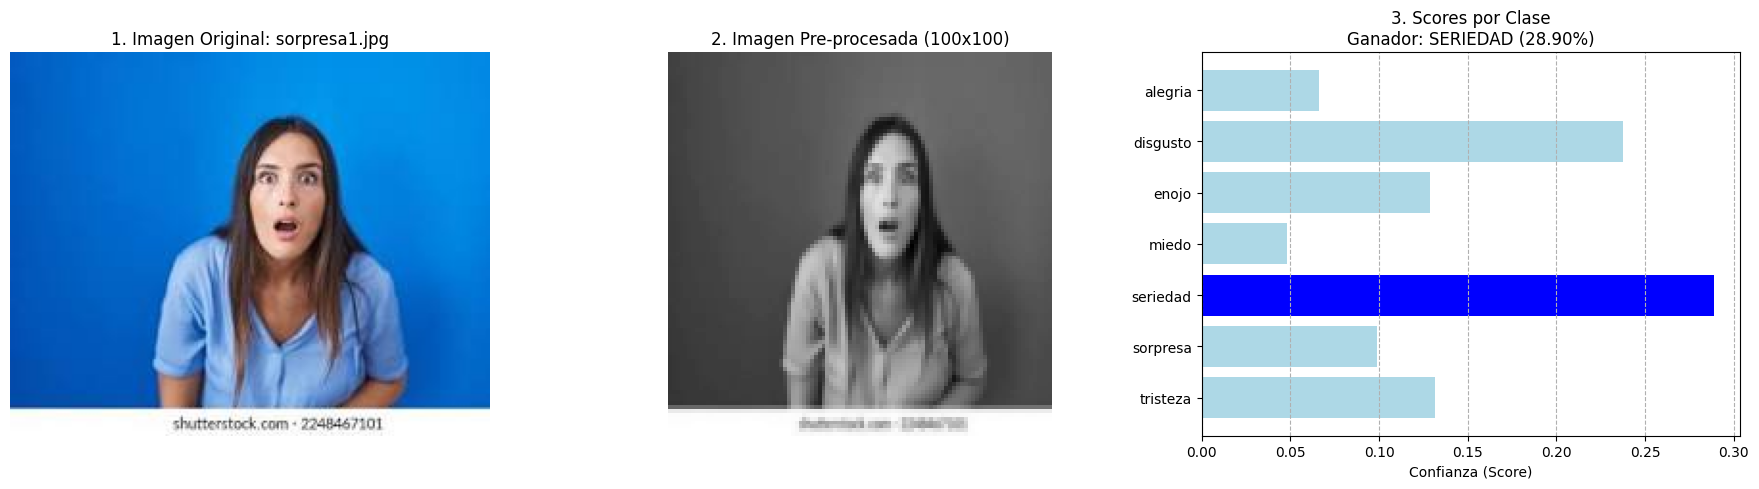

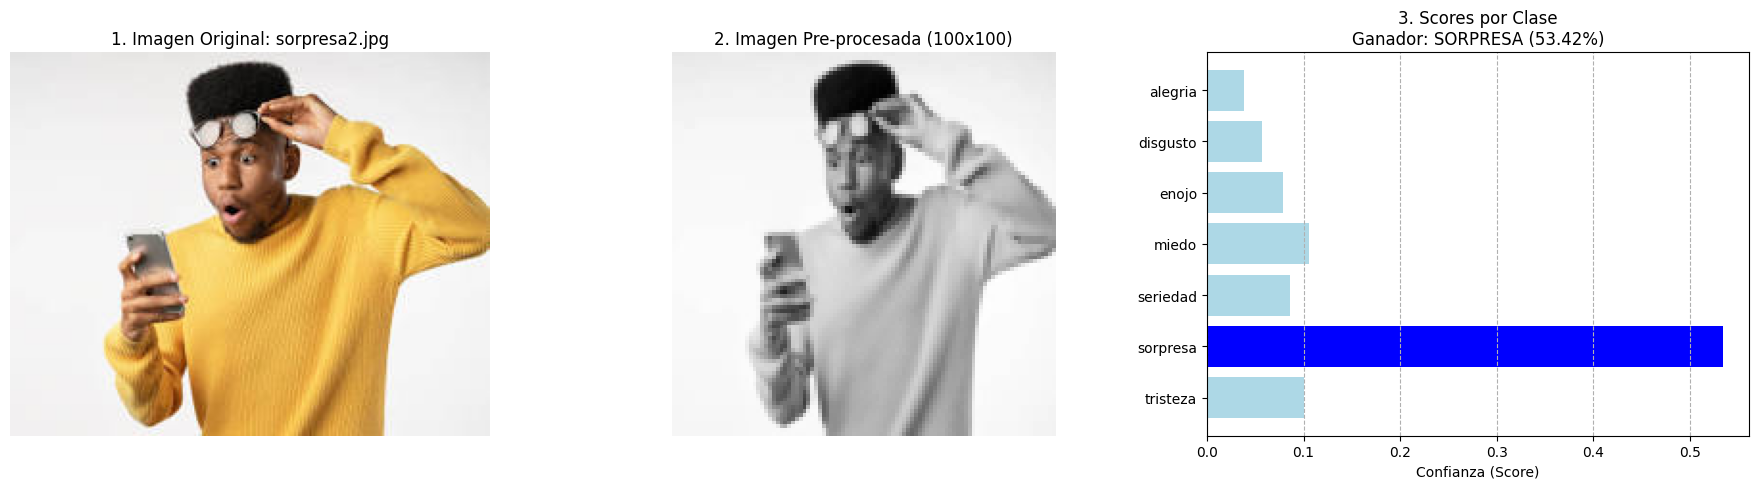

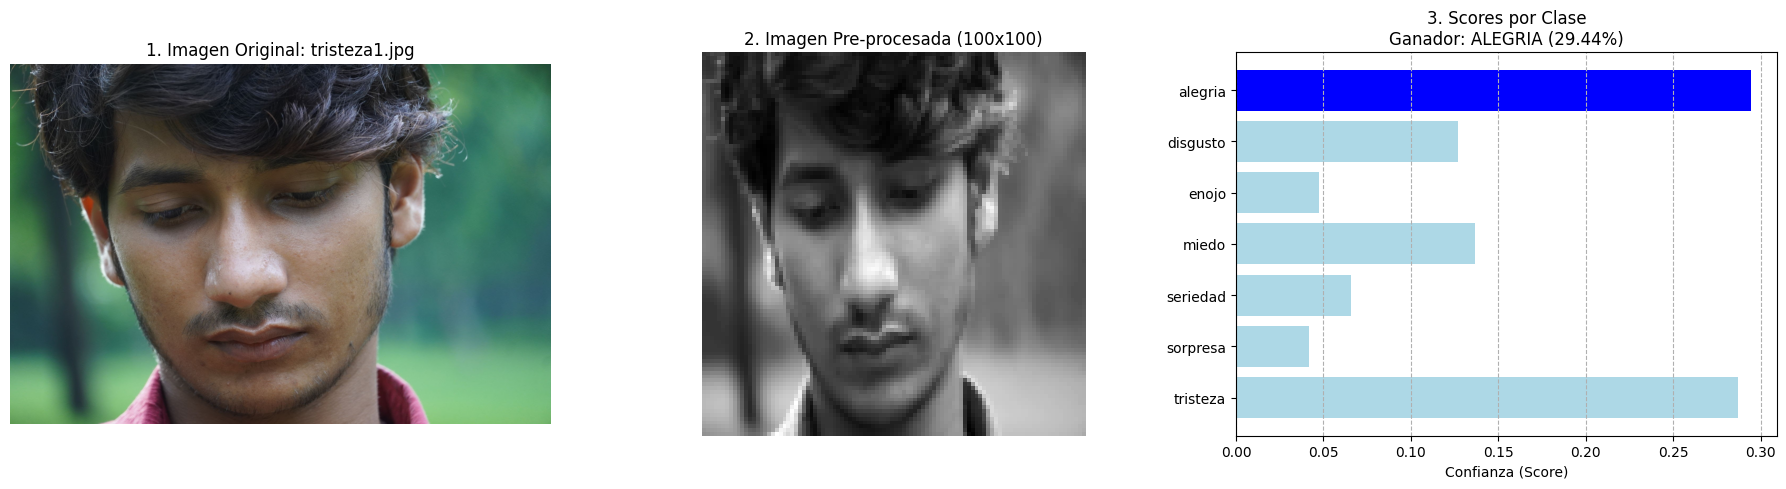

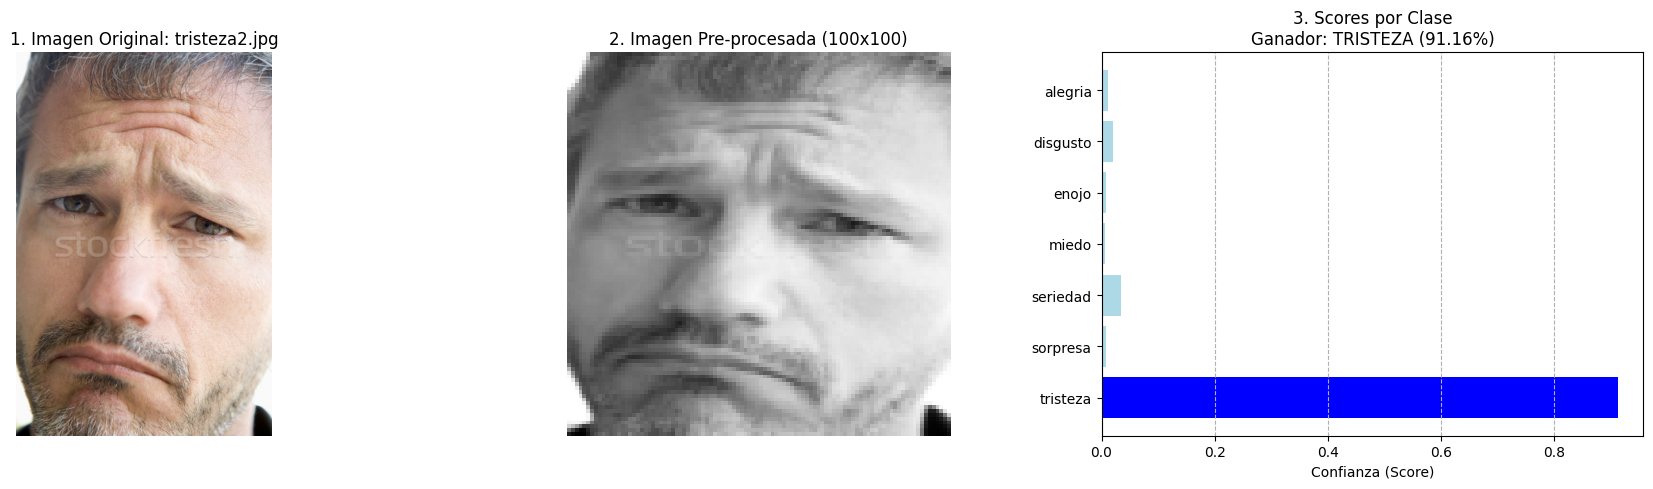

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt


#  CONFIGURACIÓN Y PARÁMETROS DEL MODELO
IMG_SIZE = 100
DATASET_MEAN = 0.48171210289001465
DATASET_STD = 0.19046492874622345
CONV_CHANNELS = [32, 64, 128, 256, 512, 1024]
KERNEL_SIZE = 5
DROPOUT_RATE = 0.5
ACTIVATION_FN = nn.GELU()
CLASS_NAMES = ['alegria', 'disgusto', 'enojo', 'miedo', 'seriedad', 'sorpresa', 'tristeza']
MODEL_PATH = 'best_emotion_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DEFINICIÓN Y CARGA DEL MODELO ---

# Re-definimos la misma arquitectura de red
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7, conv_channels=[32, 64, 128], kernel_size=3, padding="same",
                 dropout_rate=0.5, activation_fn=nn.ReLU, img_size=48):
        super(EmotionCNN, self).__init__()
        layers = []
        in_channels = 1
        for out_channels in conv_channels:
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                activation_fn,
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, img_size, img_size)
            try:
                flattened_features = self.features(dummy_input).flatten().shape[0]
            except IndexError:
                raise ValueError(f"La arquitectura es demasiado profunda para el tamaño de imagen.")
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_features, 128),
            activation_fn,
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# Instanciamos el modelo con los parámetros correctos y cargamos los pesos
model = EmotionCNN(
    num_classes=len(CLASS_NAMES),
    conv_channels=CONV_CHANNELS,
    dropout_rate=DROPOUT_RATE,
    activation_fn=ACTIVATION_FN,
    kernel_size=KERNEL_SIZE,
    img_size=IMG_SIZE
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"Modelo '{MODEL_PATH}' cargado y en modo de evaluación.")

# --- DEFINICIÓN DEL PRE-PROCESAMIENTO ---
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD])
])

# --- LISTA DE IMÁGENES A PROBAR ---
base_url = "https://raw.githubusercontent.com/Neo820712/TP-DL/main/imagenes_emociones/"
image_files = [
    "alegria1.jpg",
    "alegria2.jpg",
    "asco1.jpg",
    "asco2.jpg",
    "enojo1.jpg",
    "enojo2.jpg",
    "miedo1.jpg",
    "miedo2.jpg",
    "sorpresa1.jpg",
    "sorpresa2.jpg",
    "tristeza1.jpg",
    "tristeza2.jpg"
]
image_urls = [base_url + f for f in image_files]

# ---FUNCIÓN DE PREDICCIÓN Y VISUALIZACIÓN ---
def predict_and_visualize(image_url, model, transforms, class_names, device):
    try:

        response = requests.get(image_url)
        response.raise_for_status() # Lanza un error si la descarga falla
        img_original = Image.open(BytesIO(response.content))


        img_tensor = transforms(img_original).unsqueeze(0).to(device)


        with torch.no_grad():
            logits = model(img_tensor)
            probabilities = F.softmax(logits, dim=1).squeeze().cpu().numpy()


        winner_idx = np.argmax(probabilities)
        winner_class = class_names[winner_idx]
        winner_score = probabilities[winner_idx]


        fig, axes = plt.subplots(1, 3, figsize=(18, 5))


        axes[0].imshow(img_original)
        filename = image_url.split('/')[-1]
        axes[0].set_title(f"1. Imagen Original: {filename}")
        axes[0].axis('off')



        preprocessed_img = img_tensor.squeeze().cpu().numpy()
        preprocessed_img = (preprocessed_img * DATASET_STD) + DATASET_MEAN # Desnormalizar
        axes[1].imshow(preprocessed_img, cmap='gray')
        axes[1].set_title("2. Imagen Pre-procesada (100x100)")
        axes[1].axis('off')


        y_pos = np.arange(len(class_names))
        bar_colors = ['lightblue'] * len(class_names)
        bar_colors[winner_idx] = 'blue'
        axes[2].barh(y_pos, probabilities, color=bar_colors)
        axes[2].set_yticks(y_pos)
        axes[2].set_yticklabels(class_names)
        axes[2].invert_yaxis()
        axes[2].set_xlabel('Confianza (Score)')
        axes[2].set_title(f"3. Scores por Clase\nGanador: {winner_class.upper()} ({winner_score:.2%})")
        axes[2].grid(axis='x', linestyle='--')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"No se pudo procesar la imagen {image_url}. Error: {e}")

# --- EJECUTAR PREDICCIONES ---
for url in image_urls:
    predict_and_visualize(url, model, val_transforms, CLASS_NAMES, device)

 ## 5. Prueba de Imágenes Nuevas con Pre-procesamiento Adicional (1 punto)
Las 6 imágenes del punto 4, ahora serán pasadas y recortadas por un algoritmo de detección de rostros. Usen el siguiente código para realizar un pre-procesamiento inicial de la imagen y ya luego aplican el pre-procesamiento que usaron al momento de entrenar el modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:
  - La imagen original
  - La imagen recortada por el algoritmo
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Comparar los resultados con el punto 4 y redactar conclusiones finales.

NOTA: Pueden adaptar el código y modificar el `scaleFactor` y el `minNeighbors` según crean conveniente para obtener mejores resultados.

Modelo 'best_emotion_model.pth' cargado y en modo de evaluación.


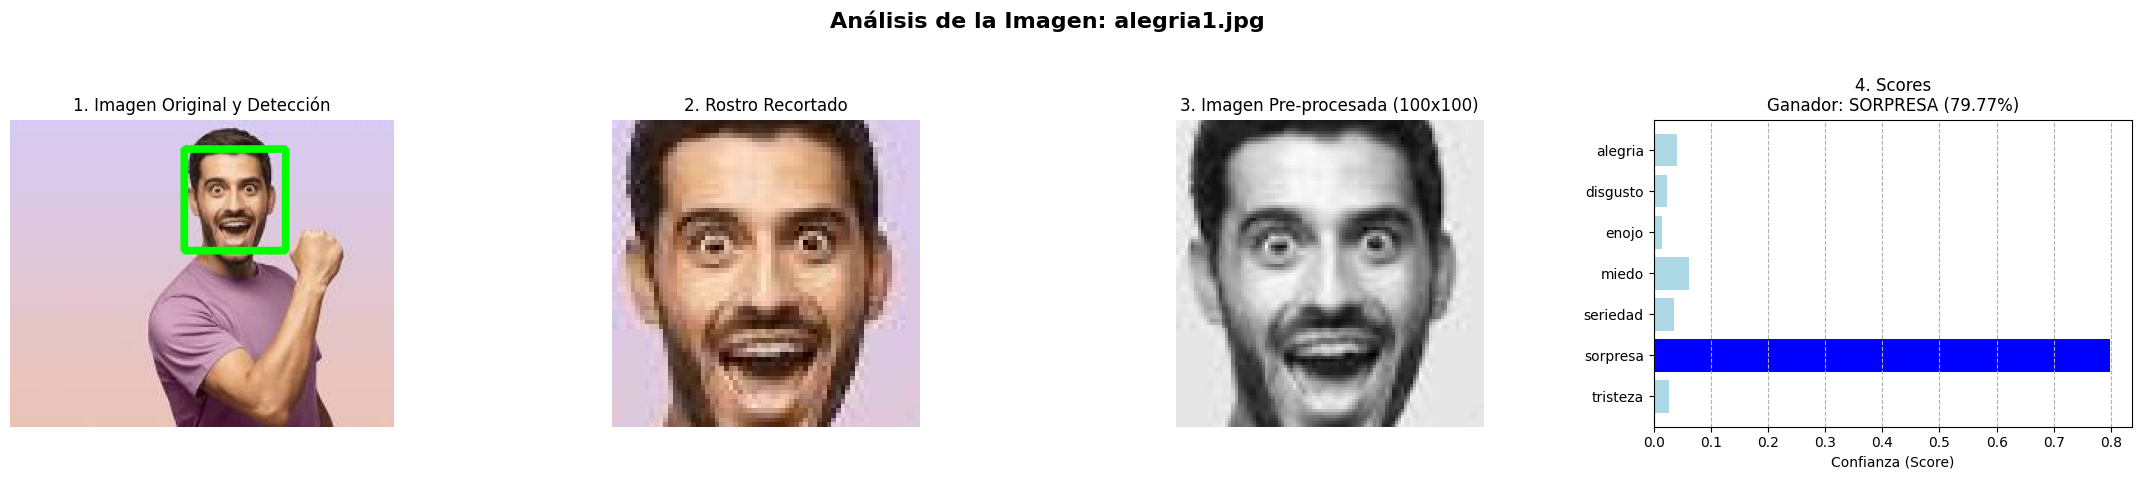

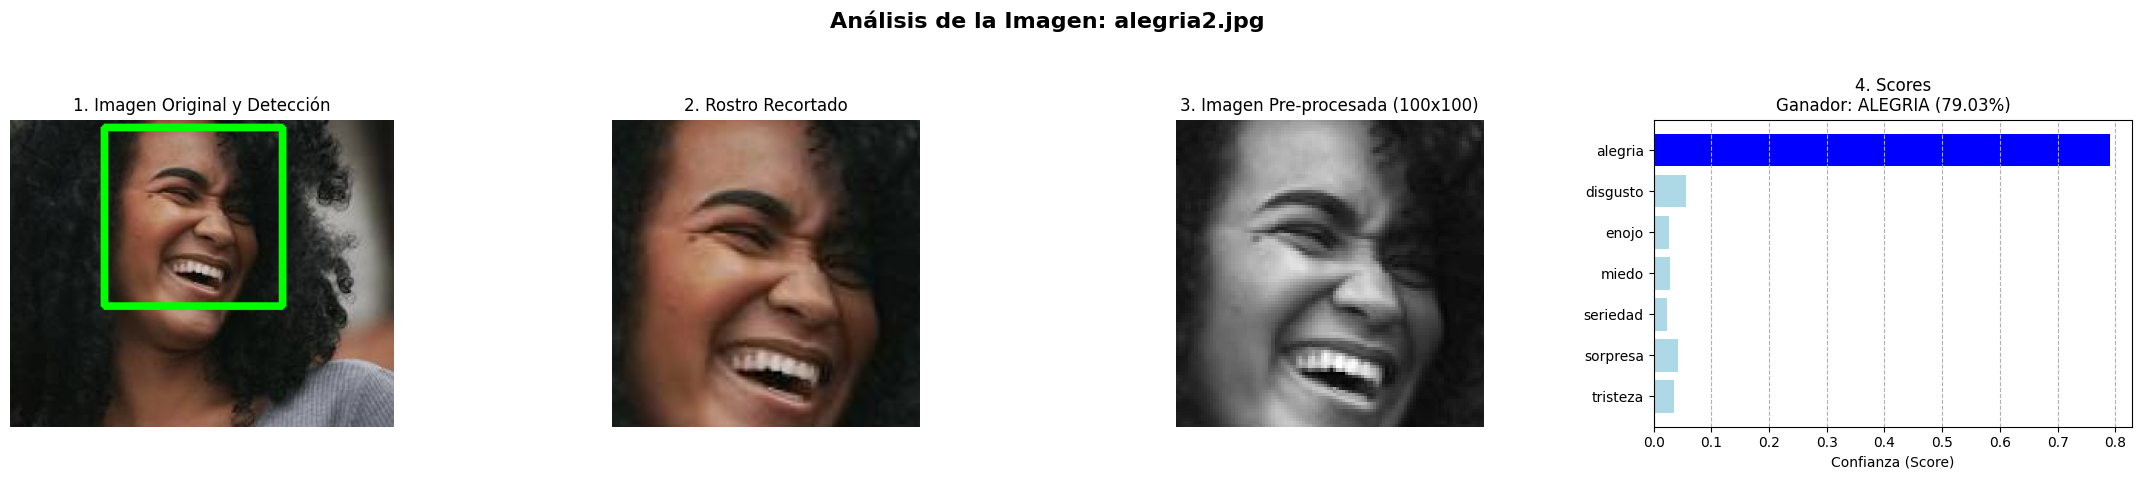

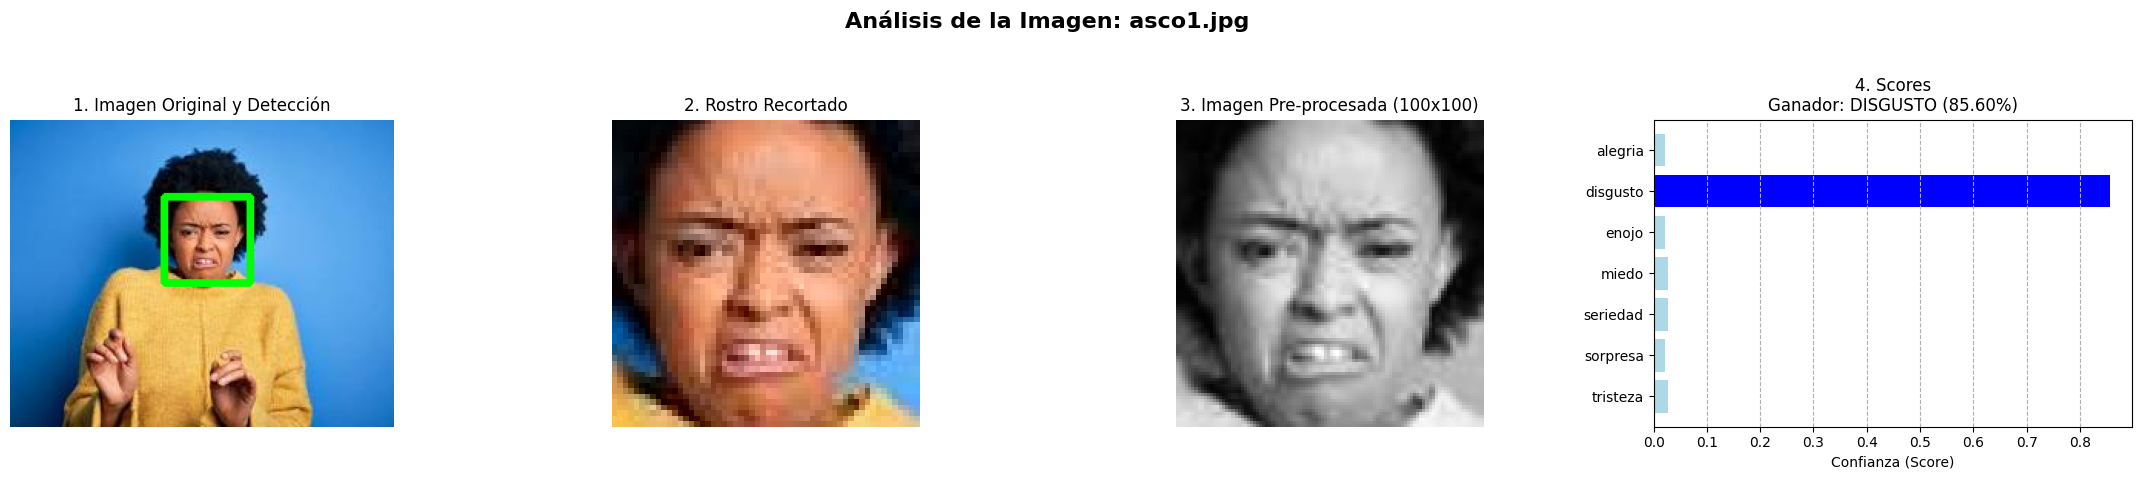

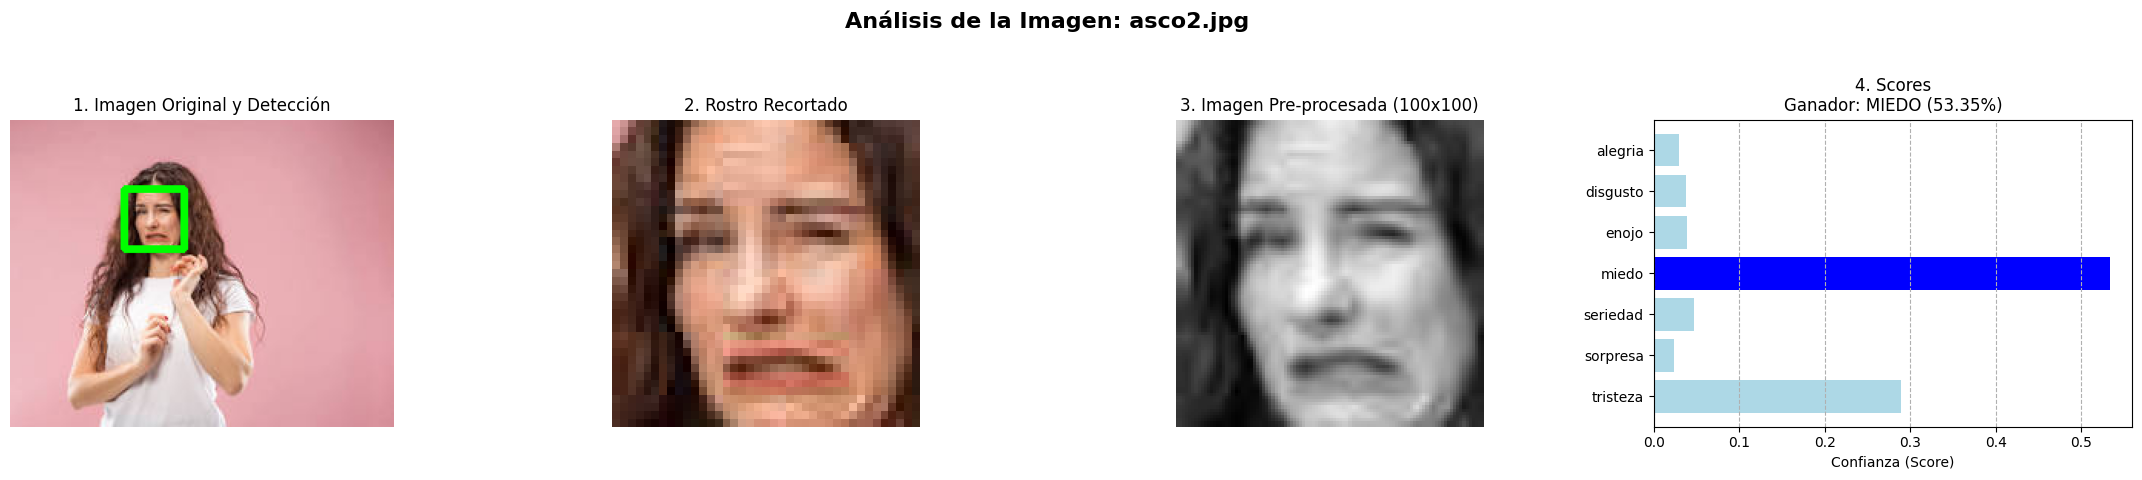

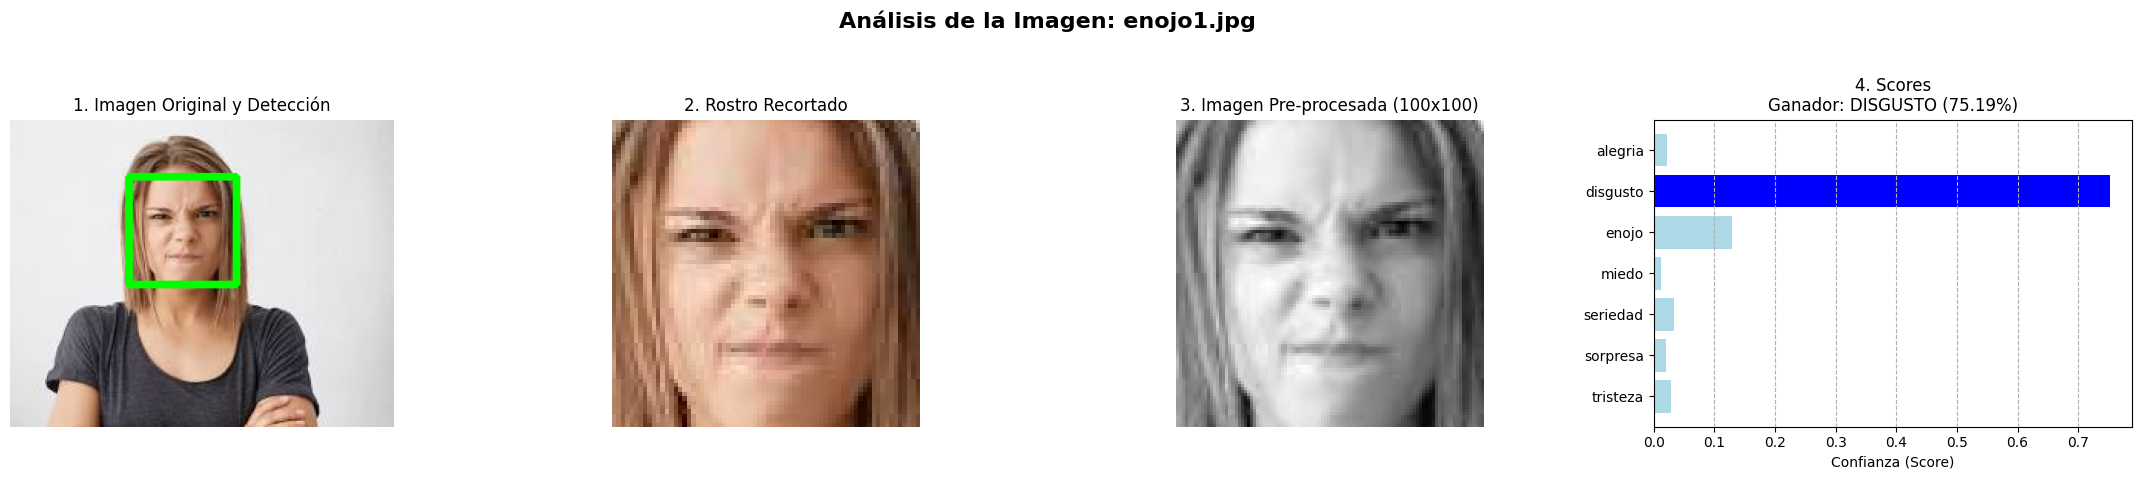

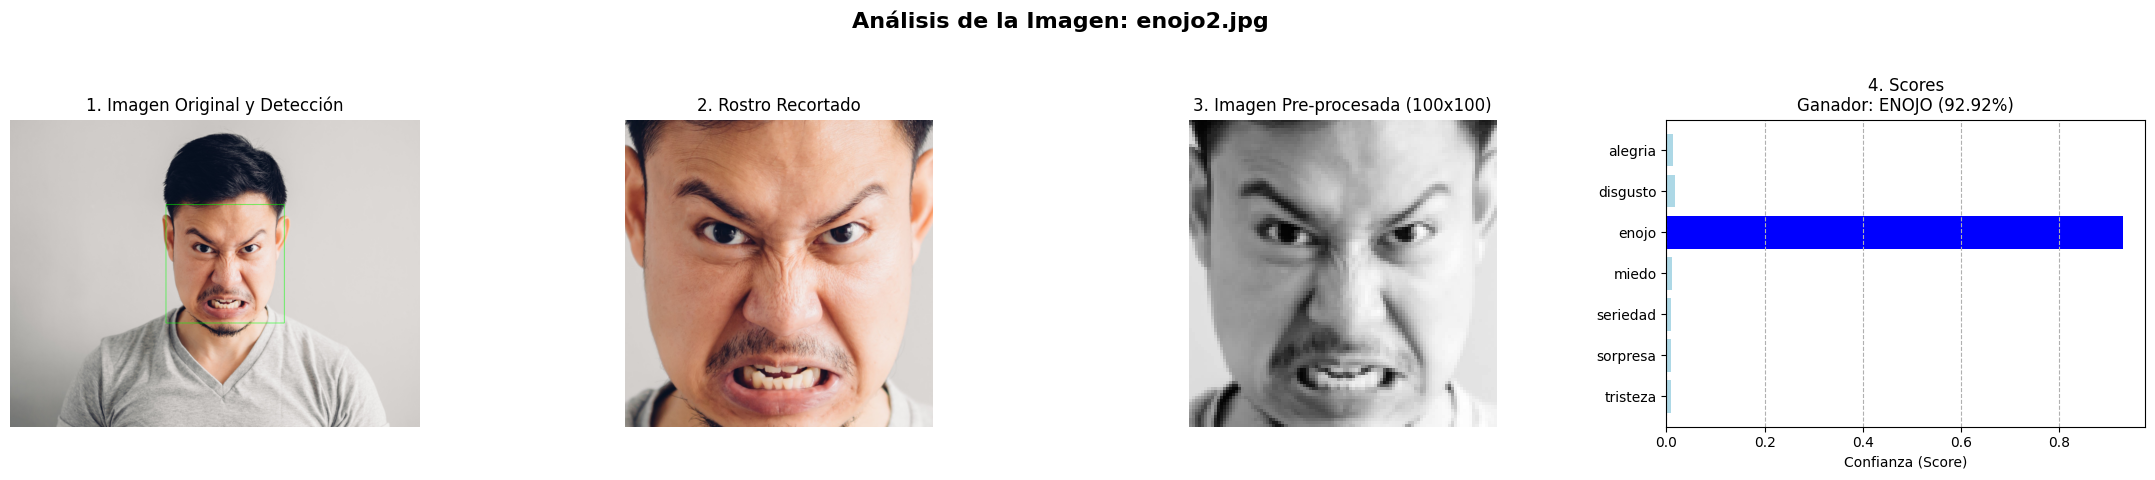

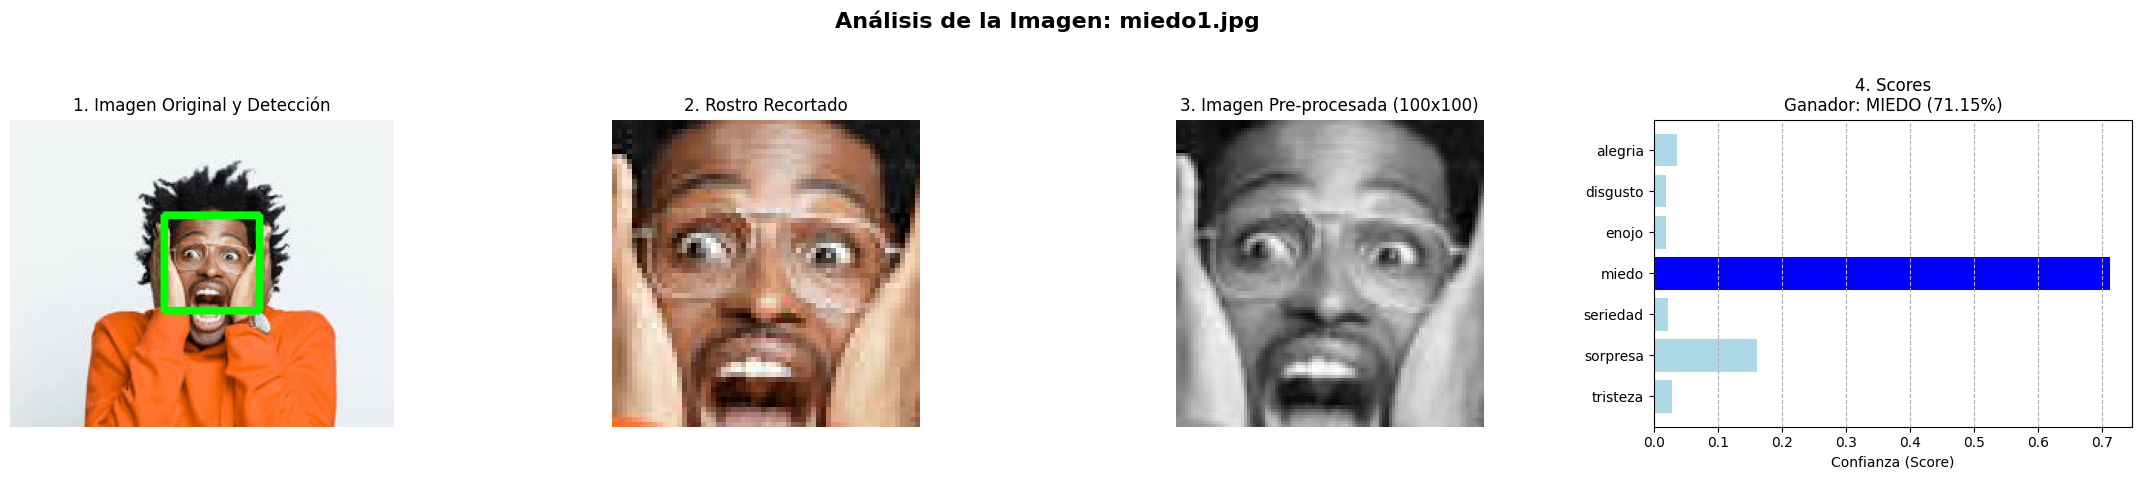

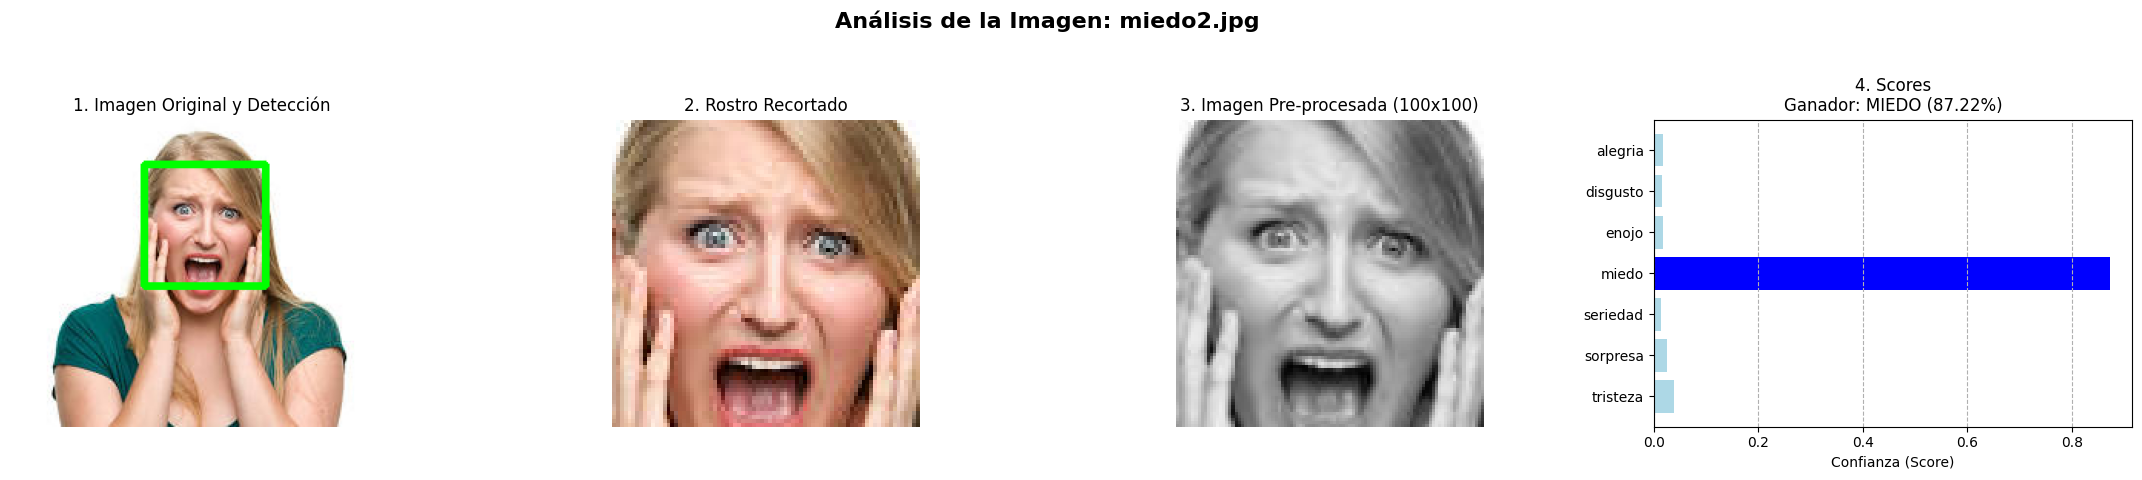

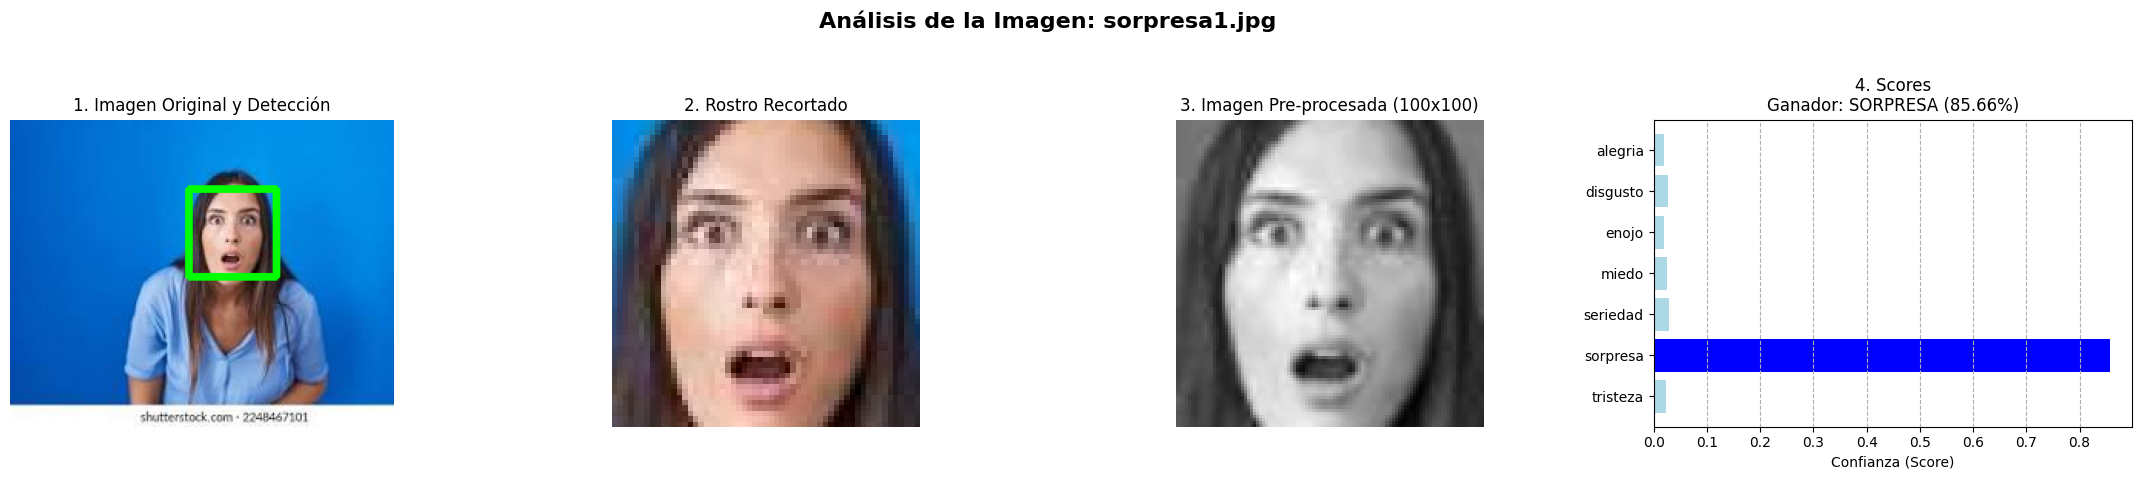

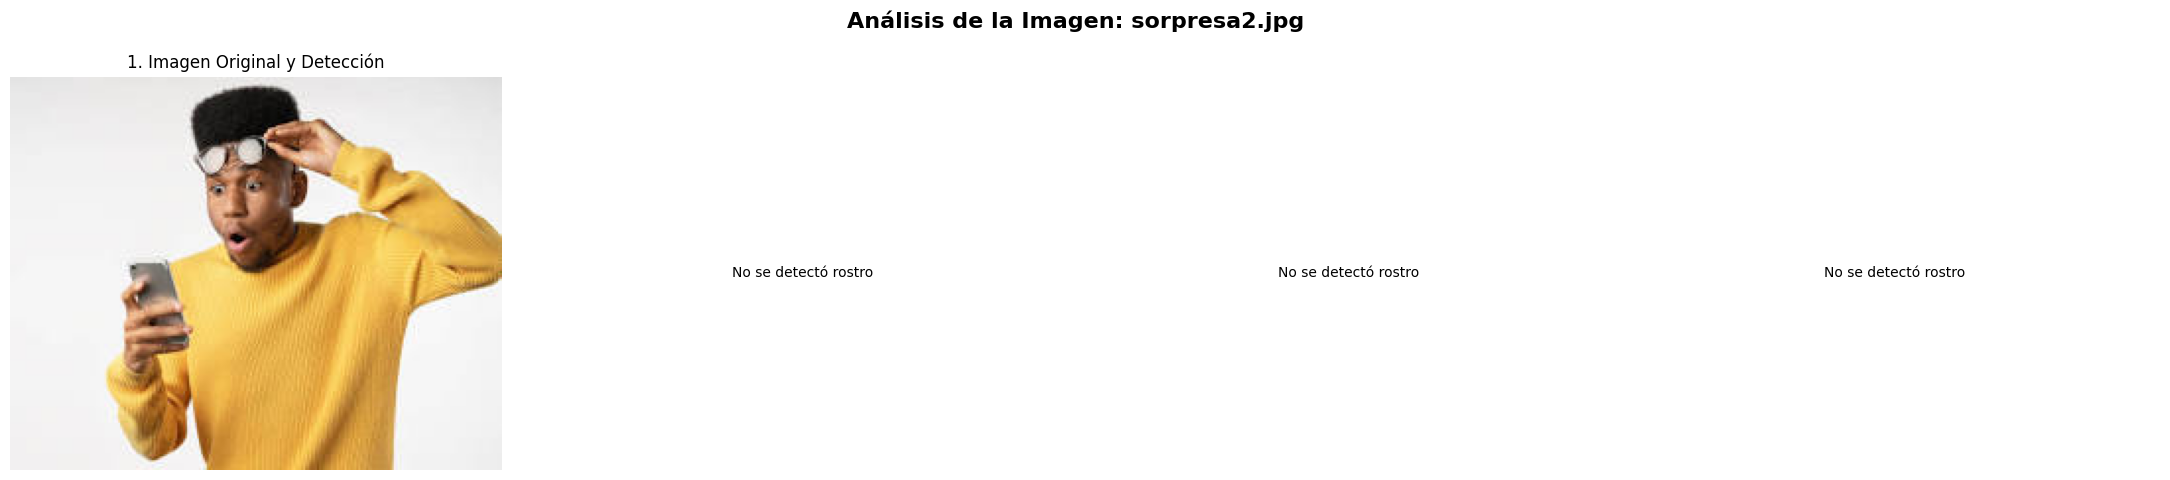

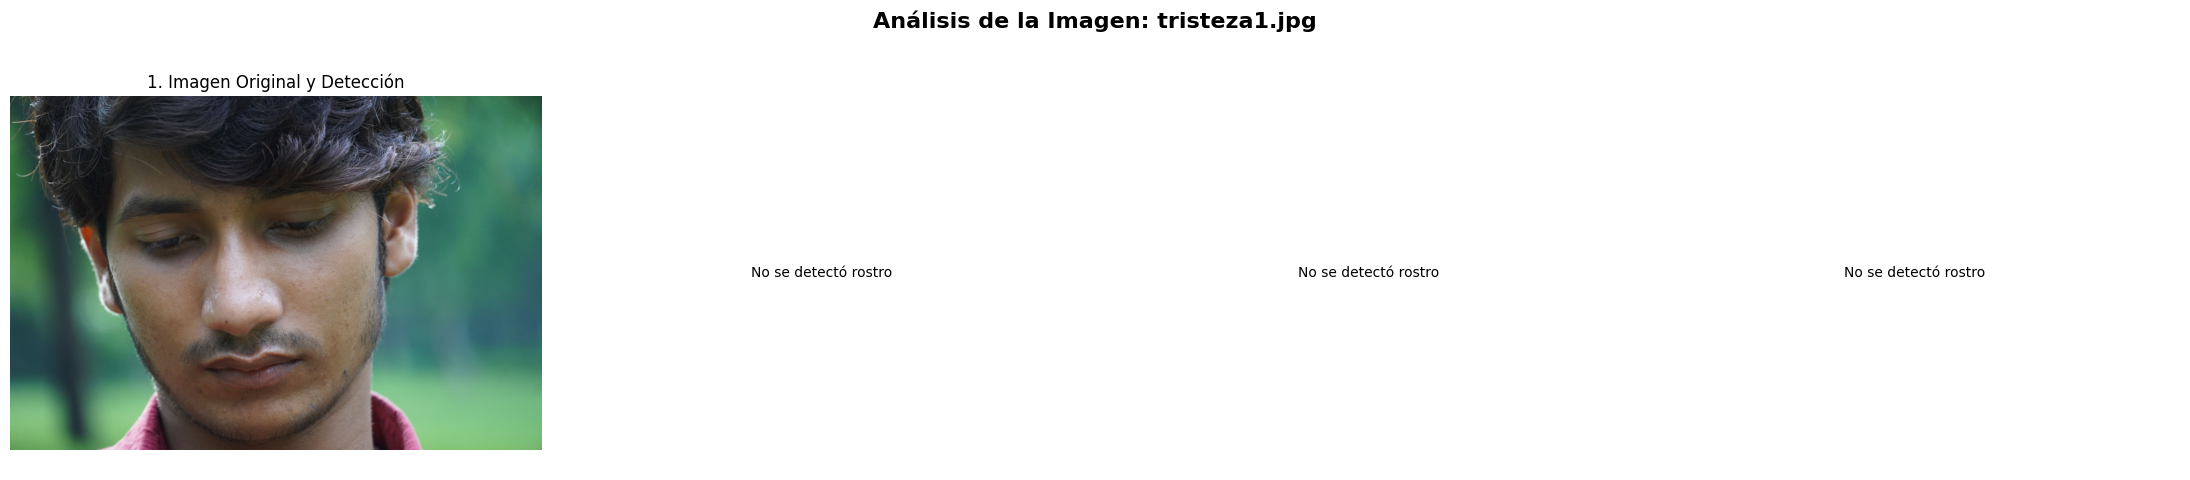

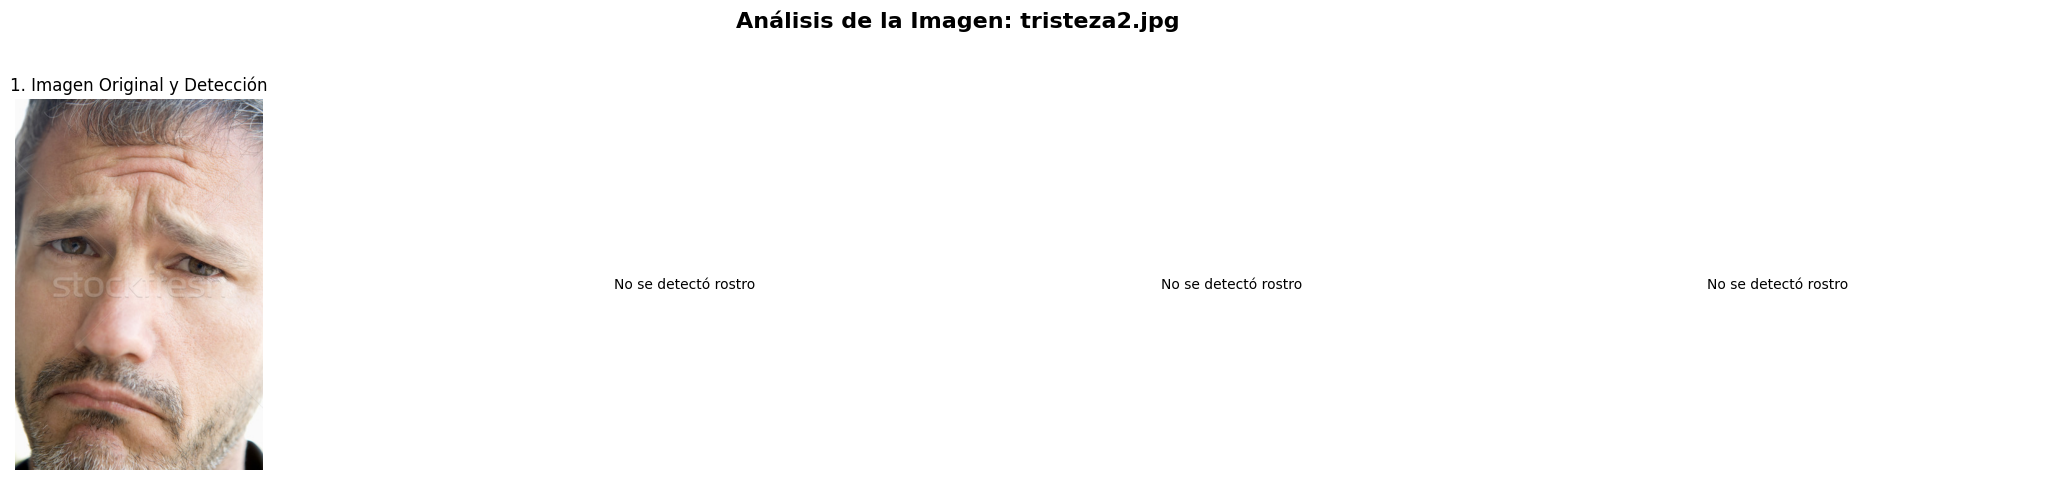

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ===================================================================
#                1. CONFIGURACIÓN Y PARÁMETROS DEL MODELO
# ===================================================================
IMG_SIZE = 100
DATASET_MEAN = 0.48171210289001465
DATASET_STD = 0.19046492874622345
CONV_CHANNELS = [32, 64, 128, 256, 512, 1024]
KERNEL_SIZE = 5
DROPOUT_RATE = 0.5
ACTIVATION_FN = nn.GELU()
CLASS_NAMES = ['alegria', 'disgusto', 'enojo', 'miedo', 'seriedad', 'sorpresa', 'tristeza']
MODEL_PATH = 'best_emotion_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ===================================================================

# --- 2. DEFINICIÓN Y CARGA DEL MODELO ---

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7, conv_channels=[32, 64, 128], kernel_size=3, padding="same",
                 dropout_rate=0.5, activation_fn=nn.ReLU, img_size=48):
        super(EmotionCNN, self).__init__()
        layers = []
        in_channels = 1
        for out_channels in conv_channels:
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                activation_fn,
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, img_size, img_size)
            try:
                flattened_features = self.features(dummy_input).flatten().shape[0]
            except IndexError:
                raise ValueError(f"La arquitectura es demasiado profunda para el tamaño de imagen.")
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_features, 128),
            activation_fn,
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = EmotionCNN(num_classes=len(CLASS_NAMES), conv_channels=CONV_CHANNELS, dropout_rate=DROPOUT_RATE,
                   activation_fn=ACTIVATION_FN, kernel_size=KERNEL_SIZE, img_size=IMG_SIZE).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"Modelo '{MODEL_PATH}' cargado y en modo de evaluación.")

# --- 3. DEFINICIÓN DEL PRE-PROCESAMIENTO ---
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD])
])

# --- 4. LISTA DE IMÁGENES A PROBAR DESDE GITHUB ---
base_url = "https://raw.githubusercontent.com/Neo820712/TP-DL/main/imagenes_emociones/"
image_files = [
    "alegria1.jpg",
    "alegria2.jpg",
    "asco1.jpg",
    "asco2.jpg",
    "enojo1.jpg",
    "enojo2.jpg",
    "miedo1.jpg",
    "miedo2.jpg",
    "sorpresa1.jpg",
    "sorpresa2.jpg",
    "tristeza1.jpg",
    "tristeza2.jpg"
]
image_urls = [base_url + f for f in image_files]

# --- 5. FUNCIÓN DE PREDICCIÓN Y VISUALIZACIÓN CON RECORTE ---
def predict_and_visualize_with_crop(image_url, model, transforms, class_names, device):
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        img_array = np.frombuffer(response.content, np.uint8)
        img_bgr = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        cropped_face_pil = None
        img_with_box = img_rgb.copy()

        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 3)
            cropped_face = img_rgb[y:y+h, x:x+w]
            cropped_face_pil = Image.fromarray(cropped_face)

        # <-- CAMBIOS REALIZADOS AQUÍ
        filename = image_url.split('/')[-1]
        fig, axes = plt.subplots(1, 4, figsize=(22, 5))
        fig.suptitle(f"Análisis de la Imagen: {filename}", fontsize=16, fontweight='bold')

        axes[0].imshow(img_with_box)
        axes[0].set_title("1. Imagen Original y Detección")
        axes[0].axis('off')

        if cropped_face_pil:
            axes[1].imshow(cropped_face_pil)
            axes[1].set_title("2. Rostro Recortado")
            axes[1].axis('off')

            img_tensor = transforms(cropped_face_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = model(img_tensor)
                probabilities = F.softmax(logits, dim=1).squeeze().cpu().numpy()

            winner_idx = np.argmax(probabilities)
            winner_class = class_names[winner_idx]
            winner_score = probabilities[winner_idx]

            preprocessed_img = img_tensor.squeeze().cpu().numpy()
            preprocessed_img = (preprocessed_img * DATASET_STD) + DATASET_MEAN
            axes[2].imshow(preprocessed_img, cmap='gray')
            axes[2].set_title("3. Imagen Pre-procesada (100x100)")
            axes[2].axis('off')

            y_pos = np.arange(len(class_names))
            bar_colors = ['lightblue'] * len(class_names)
            bar_colors[winner_idx] = 'blue'
            axes[3].barh(y_pos, probabilities, color=bar_colors)
            axes[3].set_yticks(y_pos); axes[3].set_yticklabels(class_names)
            axes[3].invert_yaxis(); axes[3].set_xlabel('Confianza (Score)')
            axes[3].set_title(f"4. Scores\nGanador: {winner_class.upper()} ({winner_score:.2%})")
            axes[3].grid(axis='x', linestyle='--')
        else:
            for i in range(1, 4):
                axes[i].text(0.5, 0.5, 'No se detectó rostro', horizontalalignment='center', verticalalignment='center')
                axes[i].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para el suptitle
        plt.show()

    except Exception as e:
        print(f"No se pudo procesar la imagen {image_url}. Error: {e}")

# --- 6. EJECUTAR PREDICCIONES ---
for url in image_urls:
    predict_and_visualize_with_crop(url, model, val_transforms, CLASS_NAMES, device)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image_path = ""

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)

image_with_box = image.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

cropped_face_rgb = None
if len(faces) > 0:
    (x, y, w, h) = faces[0]
    center_x, center_y = x + w // 2, y + h // 2
    side = max(w, h)
    half_side = side // 2

    x1 = max(center_x - half_side, 0)
    y1 = max(center_y - half_side, 0)
    x2 = min(center_x + half_side, image.shape[1])
    y2 = min(center_y + half_side, image.shape[0])

    cropped_face = image[y1:y2, x1:x2]
    cropped_face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

image_with_box_rgb = cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_with_box_rgb)
ax[0].set_title("Detección")
ax[0].axis('off')

if cropped_face_rgb is not None:
    ax[1].imshow(cropped_face_rgb)
    ax[1].set_title("Rostro recortado (relación aspecto 1:1)")
    ax[1].axis('off')
else:
    ax[1].text(0.5, 0.5, 'No se detectó rostro', horizontalalignment='center', verticalalignment='center')
    ax[1].axis('off')

plt.tight_layout()
plt.show()


# trabajo adicional
para mejorar el desempeño de modelo se hace un alternativa final con ensamble para buscar mejorar el desempeño genreal. Se deja el codigo tambien autocontenidpo  paera no tener que correr las celdas anteriores

In [ ]:
import gdown
import zipfile
import os

# --- Configuración ---
file_id = "1auZ64-CEfa4tx16cVq9TdibsdKwQY9jN"
output_zip = "emotion_dataset.zip"
extract_path = './'

# --- Descarga y Descompresión ---
gdown.download(id=file_id, output=output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# --- Verificación ---
try:
    print(f"\nContenido de '{extract_path}':")
    # Los zips a veces contienen una carpeta raíz, esto lo maneja.
    base_content = os.listdir(extract_path)
    if len(base_content) == 1 and os.path.isdir(os.path.join(extract_path, base_content[0])):
         final_path = os.path.join(extract_path, base_content[0])
         print(f"-> Subcarpeta encontrada: '{base_content[0]}'")
         print(os.listdir(final_path))
    else:
         print(base_content)
except FileNotFoundError:
    print(f"No se pudo encontrar la carpeta '{extract_path}'. Revisa el contenido del zip.")



!pip install -q torchinfo
!pip install -q torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random

# ===================================================================
#                1. CONFIGURACIÓN INICIAL Y DEL ENSEMBLE
# ===================================================================
BASE_DIR = './dataset_emociones'
DATASET_MEAN = 0.48171210289001465
DATASET_STD = 0.19046492874622345
IMG_SIZE = 100
NUM_MODELS_IN_ENSEMBLE = 5
# ===================================================================

# --- 2. CLASES Y FUNCIONES AUXILIARES ---

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7, conv_channels=[32, 64, 128], kernel_size=3, padding="same",
                 dropout_rate=0.5, activation_fn=nn.ReLU, img_size=48):
        super(EmotionCNN, self).__init__()
        layers = []
        in_channels = 1
        for out_channels in conv_channels:
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                activation_fn,
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, img_size, img_size)
            try: flattened_features = self.features(dummy_input).flatten().shape[0]
            except IndexError: raise ValueError(f"Arquitectura muy profunda para IMG_SIZE de {img_size}.")
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(flattened_features, 128), activation_fn,
            nn.Dropout(p=dropout_rate), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, y_true, y_pred = 0.0, [], []
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy()); y_true.extend(labels.cpu().numpy())
    return running_loss/len(dataloader.sampler), accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro', zero_division=0)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, y_true, y_pred = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy()); y_true.extend(labels.cpu().numpy())
    return running_loss/len(dataloader.dataset), accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro', zero_division=0)

# --- 3. PREPARACIÓN DE DATOS ---
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.TrivialAugmentWide(), transforms.ToTensor(),
    transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), transforms.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD])
])
train_dataset = datasets.ImageFolder(root=os.path.join(BASE_DIR, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(root=os.path.join(BASE_DIR, 'validation'), transform=val_transforms)
CLASS_NAMES = train_dataset.classes

# ===================================================================
#                4. HIPERPARÁMETROS DEL MODELO BASE
# ===================================================================
LEARNING_RATE = 5e-4
DROPOUT_RATE = 0.5
WEIGHT_DECAY = 0.01
BATCH_SIZE = 128
ACTIVATION_FN = nn.GELU()
CONV_CHANNELS = [32, 64, 128, 256, 512, 1024]
KERNEL_SIZE = 5
NUM_EPOCHS = 150
EARLY_STOPPING_PATIENCE = 20
# ===================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ===================================================================
#                FASE 1: ENTRENAMIENTO DEL ENSEMBLE
# ===================================================================
for model_idx in range(NUM_MODELS_IN_ENSEMBLE):
    model_path = f'ensemble_model_{model_idx}.pth'
    print("\n" + "="*80); print(f"--- PROCESANDO MODELO {model_idx+1}/{NUM_MODELS_IN_ENSEMBLE} ---")
    if os.path.exists(model_path):
        print(f"El modelo '{model_path}' ya existe. Saltando entrenamiento."); continue
    set_seed(model_idx)
    class_counts = np.bincount(train_dataset.targets)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[train_dataset.targets]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    model = EmotionCNN(num_classes=len(CLASS_NAMES), conv_channels=CONV_CHANNELS, dropout_rate=DROPOUT_RATE, activation_fn=ACTIVATION_FN, kernel_size=KERNEL_SIZE, img_size=IMG_SIZE).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=False)
    best_val_f1 = -1; patience_counter = 0; best_model_state_dict = None
    print(f"🚀 Iniciando entrenamiento para el modelo {model_idx}...")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1; patience_counter = 0; best_model_state_dict = model.state_dict().copy()
        else:
            patience_counter += 1
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{NUM_EPOCHS} | Val F1: {val_f1:.4f} | Paciencia: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
        scheduler.step(val_f1)
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"  Parada anticipada en la época {epoch+1}"); break
    print(f"✅ Entrenamiento finalizado para el modelo {model_idx}. Mejor F1: {best_val_f1:.4f}")
    torch.save(best_model_state_dict, model_path)
    print(f"Modelo guardado en '{model_path}'")

# ===================================================================
#                FASE 2: EVALUACIÓN COMPLETA DEL ENSEMBLE
# ===================================================================
print("\n" + "="*80); print("--- EVALUANDO EL RENDIMIENTO DEL ENSEMBLE COMPLETO ---")

models = []
for model_idx in range(NUM_MODELS_IN_ENSEMBLE):
    model_path = f'ensemble_model_{model_idx}.pth'
    model = EmotionCNN(num_classes=len(CLASS_NAMES), conv_channels=CONV_CHANNELS, dropout_rate=DROPOUT_RATE, activation_fn=ACTIVATION_FN, kernel_size=KERNEL_SIZE, img_size=IMG_SIZE).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    models.append(model)
print(f"Cargados {len(models)} modelos para el ensemble.")

def evaluate_ensemble(models, loader, device):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluando Ensemble"):
            inputs = inputs.to(device)
            all_model_probs = [F.softmax(model(inputs), dim=1) for model in models]
            avg_probs = torch.stack(all_model_probs).mean(dim=0)
            _, preds = torch.max(avg_probs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# --- 2.1 Reporte de Clasificación y Gráfica de Barras ---
y_true, y_pred_ensemble = evaluate_ensemble(models, val_loader, device)
print("\n" + "="*60 + "\n--- Reporte de Clasificación Final del ENSEMBLE ---\n")
print(classification_report(y_true, y_pred_ensemble, target_names=CLASS_NAMES))
report_df = pd.DataFrame(classification_report(y_true, y_pred_ensemble, target_names=CLASS_NAMES, output_dict=True)).transpose()
report_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar', figsize=(14, 8), rot=45)
plt.title('Métricas por Emoción (Ensemble)', fontweight='bold'); plt.ylabel('Puntaje'); plt.grid(axis='y', linestyle='--'); plt.tight_layout(); plt.show()

# --- 2.2 Matrices de Confusión ---
print("\n" + "="*60 + "\n--- Matrices de Confusión del ENSEMBLE ---\n")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Análisis de la Matriz de Confusión del Ensemble', fontsize=16, fontweight='bold')
cm_abs = confusion_matrix(y_true, y_pred_ensemble)
sns.heatmap(cm_abs, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_title('Matriz de Confusión Absoluta', fontweight='bold'); axes[0].set_ylabel('Clase Real'); axes[0].set_xlabel('Clase Predicha')
cm_norm = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='viridis', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1], cbar_kws={'label': 'Porcentaje (%)'})
axes[1].set_title('Matriz de Confusión Normalizada (%)', fontweight='bold'); axes[1].set_ylabel('Clase Real'); axes[1].set_xlabel('Clase Predicha')
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

# --- 2.3 Análisis de Errores del Ensemble ---
def plot_ensemble_misclassified(y_true, y_pred, full_dataset, class_names, mean, std, n=15):
    print("\n" + "="*80 + "\n--- ANÁLISIS DE ERRORES DEL ENSEMBLE ---\n")
    misclassified_indices = np.where(y_true != y_pred)[0]

    unorm = transforms.Normalize(mean=[-mean/std], std=[1/std])
    fig, axes = plt.subplots(int(np.ceil(n/5)), 5, figsize=(20, 4 * int(np.ceil(n/5))))
    fig.suptitle('Ejemplos de Clasificaciones Incorrectas del Ensemble', fontsize=20, fontweight='bold')
    axes = axes.flatten()

    for i, idx in enumerate(misclassified_indices[:n]):
        img_tensor, true_idx = full_dataset[idx]
        pred_idx = y_pred[idx]

        ax = axes[i]
        img = unorm(img_tensor)
        img = img.permute(1, 2, 0)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Real: {class_names[true_idx]}\nPred: {class_names[pred_idx]}", color='red')
        ax.set_xticks([]); ax.set_yticks([])

    # Ocultar ejes no utilizados
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

plot_ensemble_misclassified(y_true, y_pred_ensemble, val_dataset, CLASS_NAMES, DATASET_MEAN, DATASET_STD)